In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore', '', UserWarning)

import torch
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [2]:
import os
os.chdir('..')

In [3]:
os.makedirs('data/celeba', exist_ok=True)

In [4]:
from setup import download_CELEBA
download_CELEBA('data/celeba')

data/celeba/img_align_celeba.zip: 44.1kB [01:03, 698B/s]


In [5]:
from torchvision.transforms import CenterCrop, Resize
from PIL import Image

def preprocess(paths):
    base_path, target_path, file = paths
    downsample_size = 64
    img = Image.open(os.path.join(base_path, file))
    crop = CenterCrop(img.width)
    scale = Resize(downsample_size)
    img = scale(crop(img))
    img.save(os.path.join(target_path, file.replace('jpg', 'png')))

In [6]:
import os
from multiprocessing import Pool
from tqdm import tqdm

base_path = 'data/celeba/img_align_celeba'
target_path = 'data/celeba/preprocessed64'
os.makedirs(target_path, exist_ok=True)
files = os.listdir(base_path)
paths = [(base_path, target_path, f) for f in files]
pool = Pool()
processes = pool.imap_unordered(preprocess, paths)
iterator = tqdm(processes, total=len(paths))
for _ in iterator:
    pass
pool.close()
pool.join()

100%|██████████| 202599/202599 [05:00<00:00, 674.02it/s]


In [7]:
dataset_params = {
    'dataset': 'celeba64',
    'batch_size': 32,
    'cuda': True,
    'root': 'data'
}

from src.utils import get_datasets
train_loader, test_loader, (width, height, channels) = get_datasets(
    **dataset_params)

Loading celeba64 dataset...
Done!



In [9]:
%%time
from src.models.conv_vsc import ConvolutionalVariationalSparseCoding

model_params = {
    'dataset': 'celeba64',
    'width': width,
    'height': height,
    'channels': channels,
    'kernel_szs': '32,32,64,64',
    'hidden_sz': 256,
    'latent_sz': 200,
    'learning_rate': 3e-4,
    
    'alpha': 0.1,
    'beta': 1.25,
    'beta_delta': 0,
    'c': 50,
    'c_delta': 1e-3, 
    
    'device': 'cpu',
    'log_interval': 1000,
    'normalize': False,
    'flatten': False
}

convvsc = ConvolutionalVariationalSparseCoding(**model_params)


CPU times: user 17.4 ms, sys: 4.88 ms, total: 22.3 ms
Wall time: 21.6 ms


In [10]:
convvsc.model.load_state_dict(torch.load(
    'data/checkpoints/convvsc_celeba_15e_200z.pth', map_location='cpu'))

In [11]:
images, _ = iter(test_loader).next()

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision

def plot_image(img, ax, title):
    ax.imshow(np.transpose(img, (1,2,0)) , interpolation='nearest')
    ax.set_title(title, fontsize=20)
    
def to_numpy(image, vsc):
    return torchvision.utils.make_grid(
        image.view(1, vsc.channels, vsc.height, vsc.width)
    ).cpu().detach().numpy()
    
def plot_encoding(image, vsc, latent_sz, alpha, width=1/7):
    image = vsc.transform(image).to(vsc.device)
    decoded, mu, logvar, logspike = vsc.model.forward(image)
    z = vsc.model.reparameterize(mu, logvar, logspike)
    img = vsc.inverse_transform(vsc.model.decode(z))
    z = z.cpu().detach().numpy()[0]
    
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(14,5))
    
    plot_image(to_numpy(image, vsc), ax0, 'Input Image')
    
    ax1.bar(np.arange(latent_sz), height=z, width=width, align='center')
    ax1.scatter(np.arange(latent_sz), z, color='blue')
    ax1.set_title(r"Latent Dimension %d - $\alpha$ = %.2f " % \
                  (latent_sz, alpha), fontsize=20)
    
    plot_image(to_numpy(img, vsc), ax2, 'Decoded Image')
    plt.subplots_adjust(hspace=0.5)

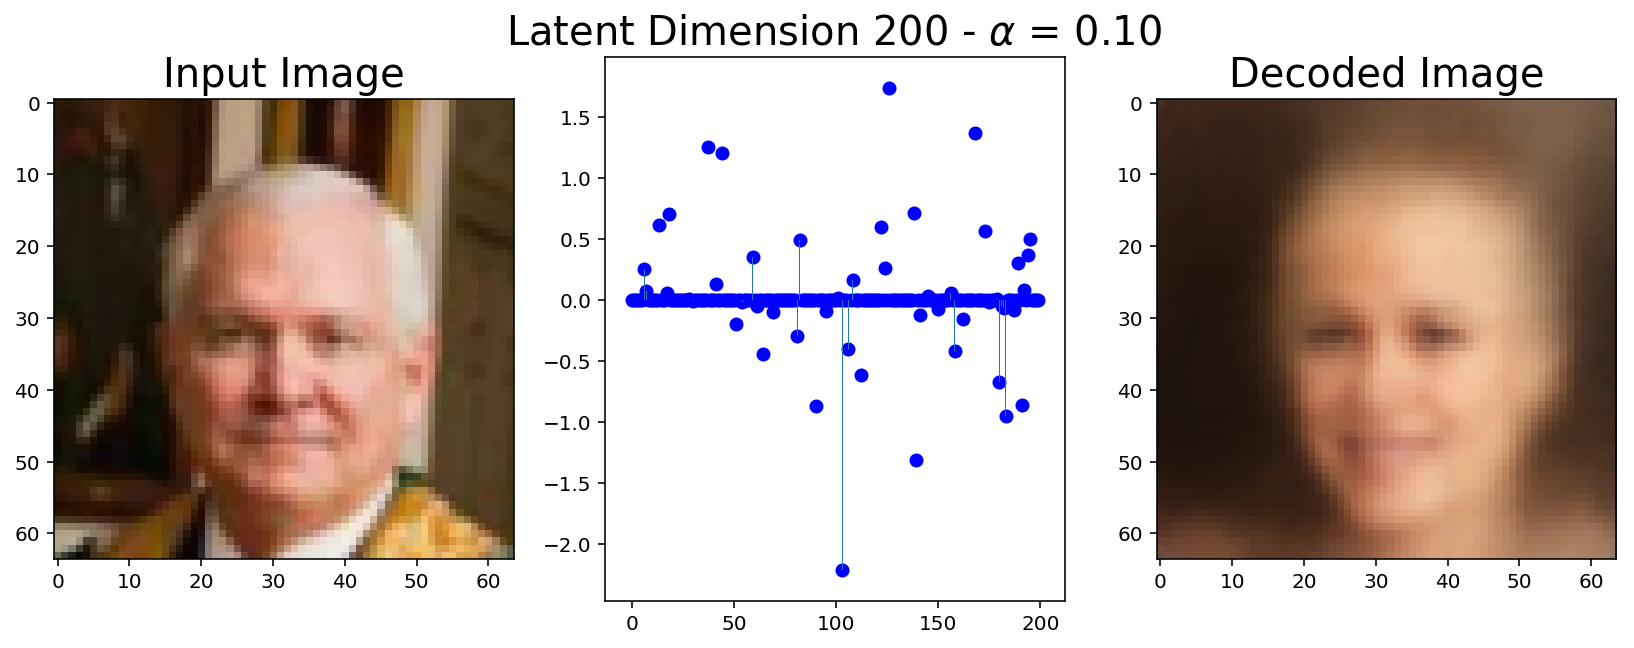

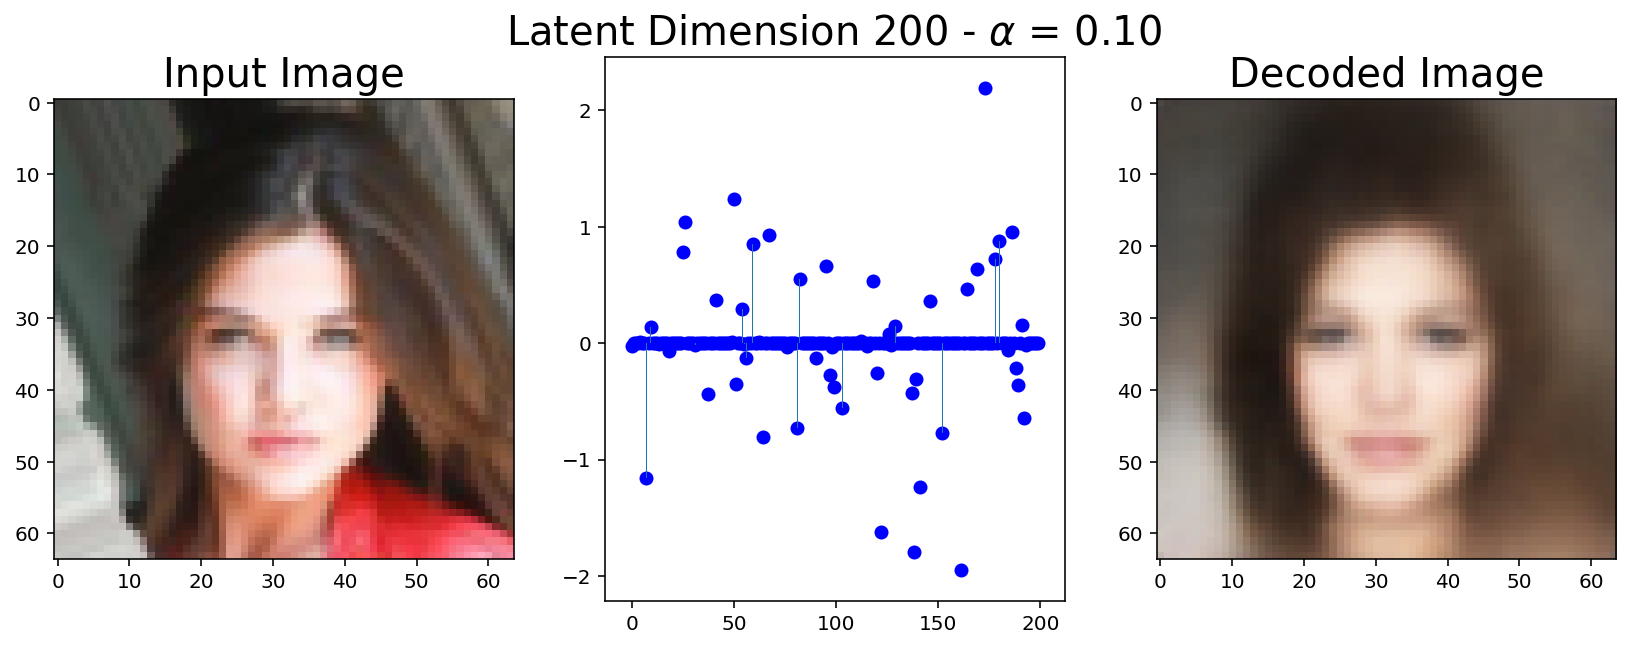

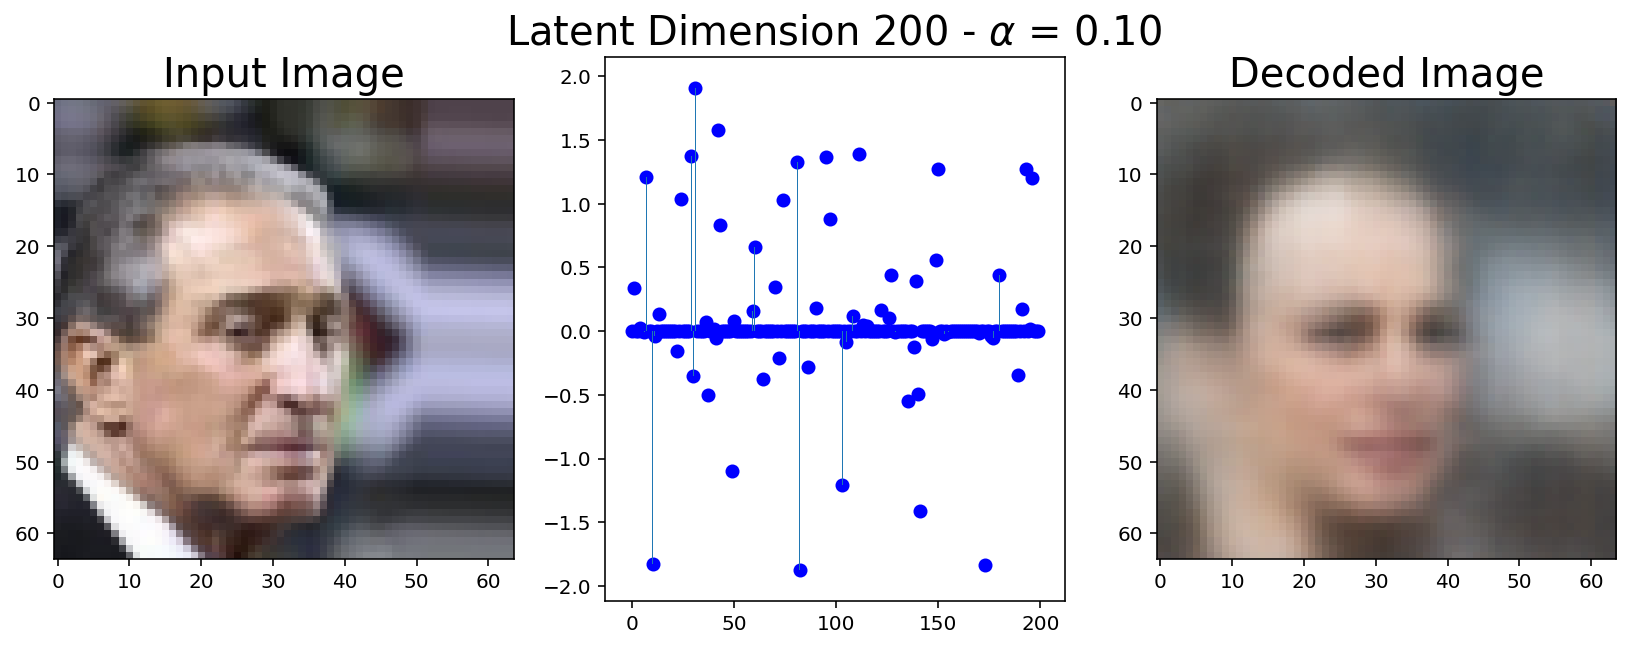

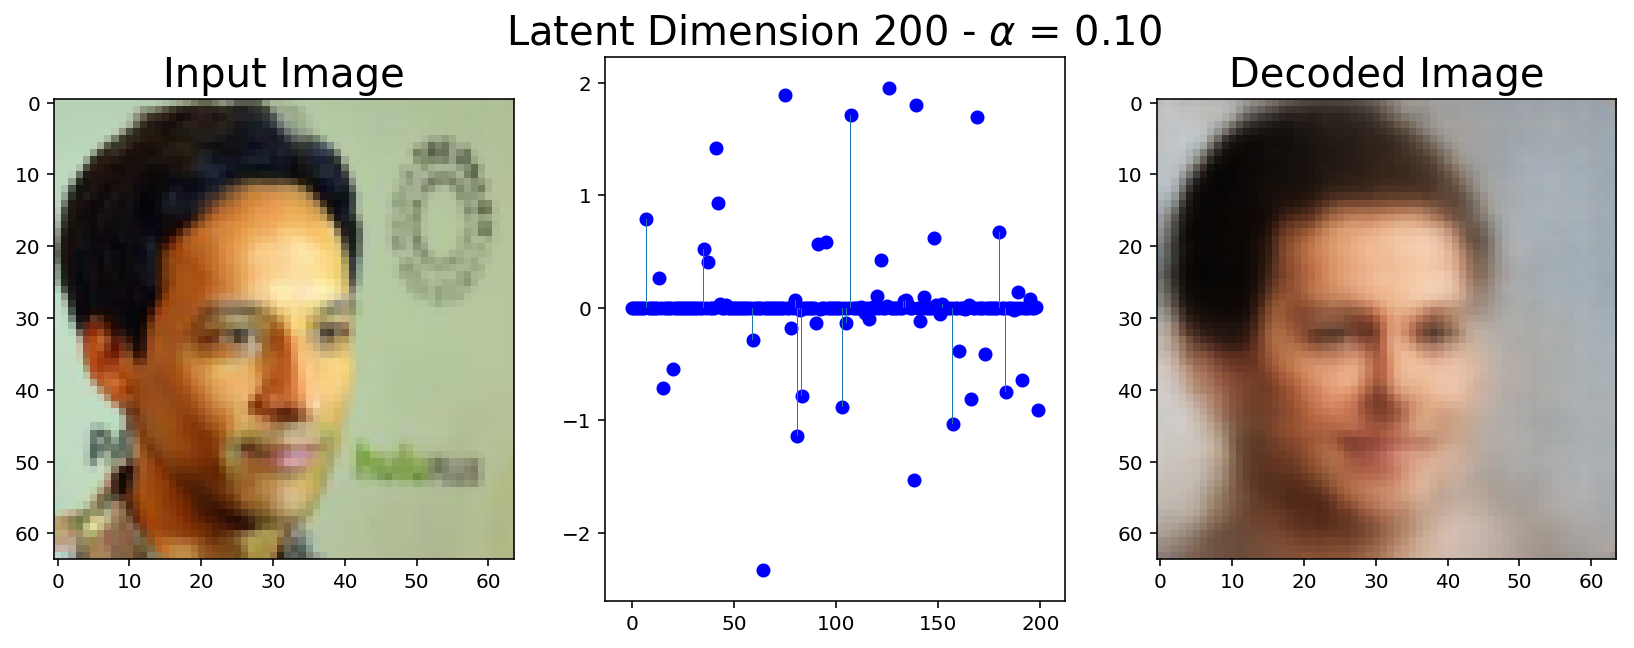

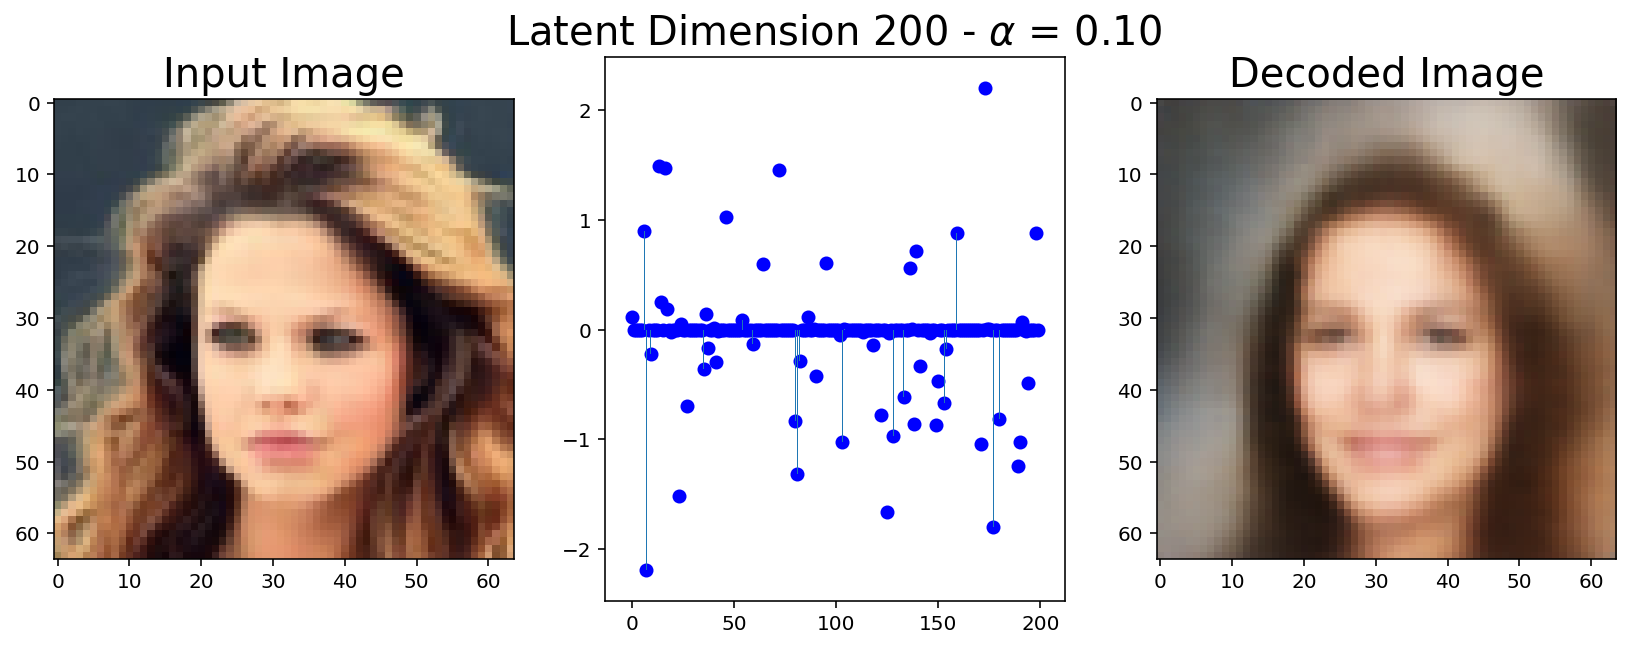

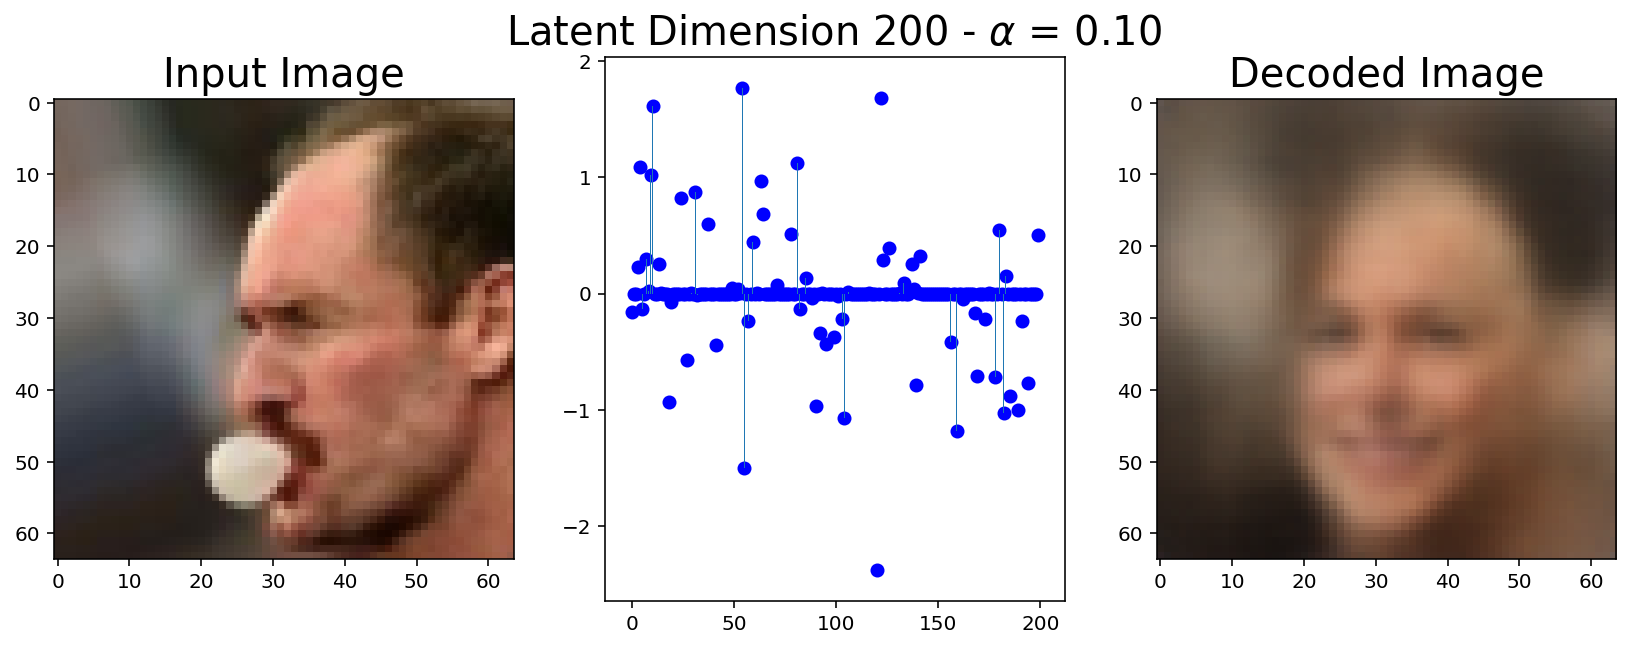

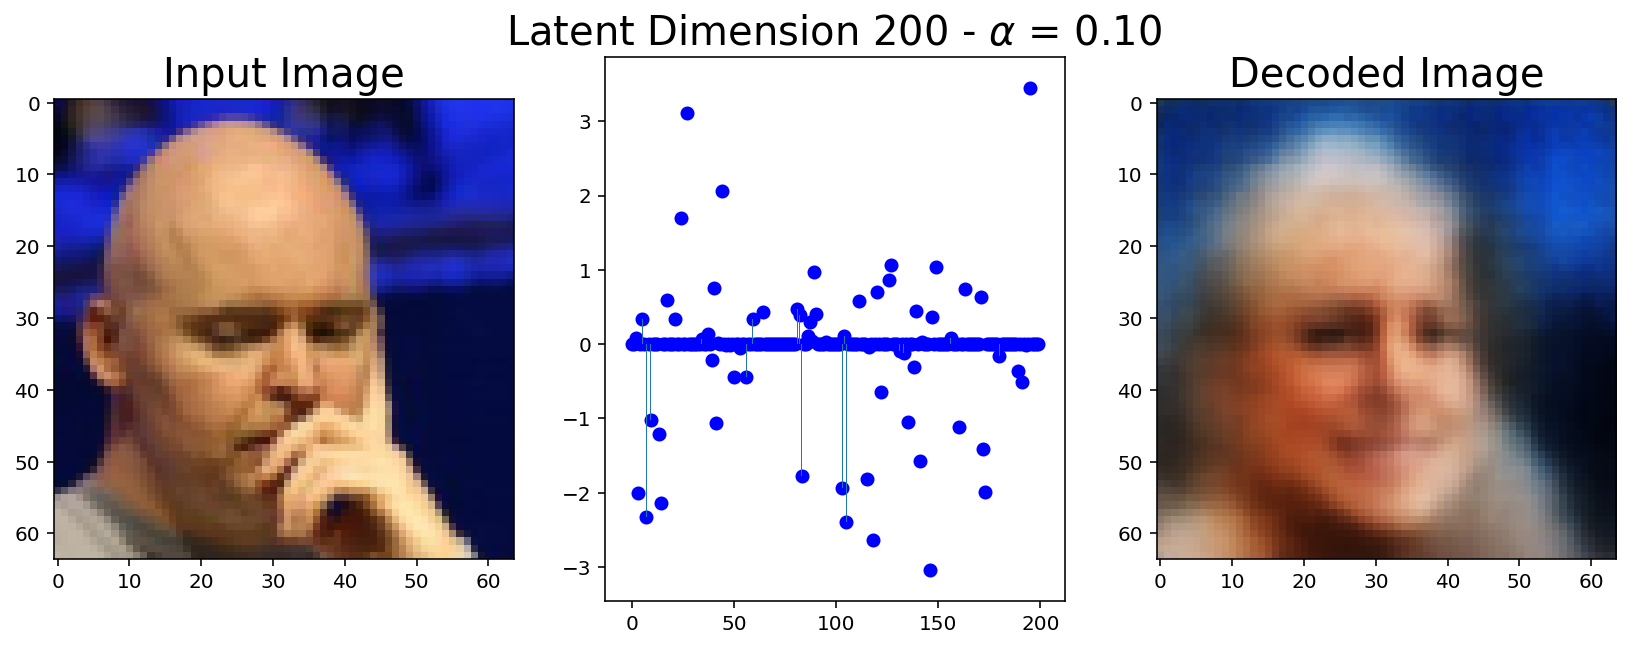

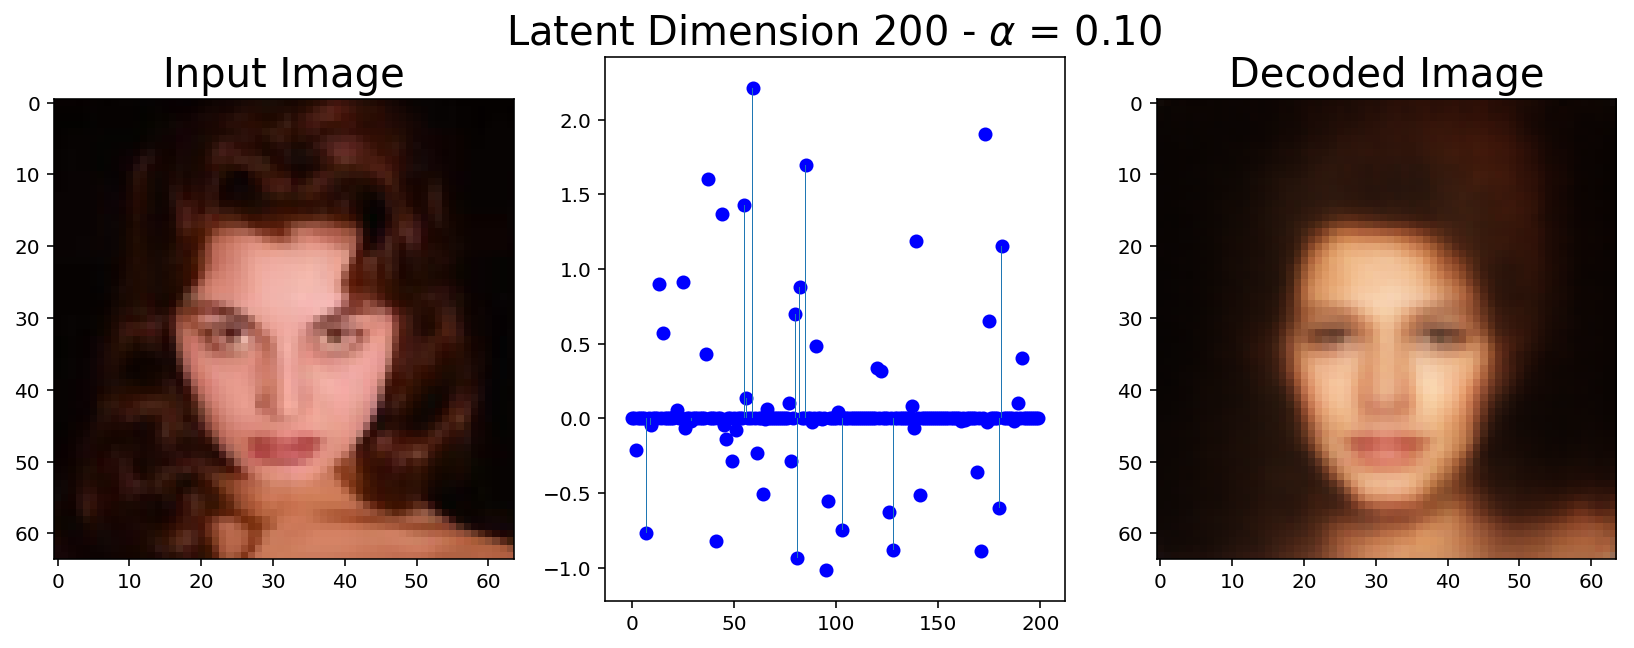

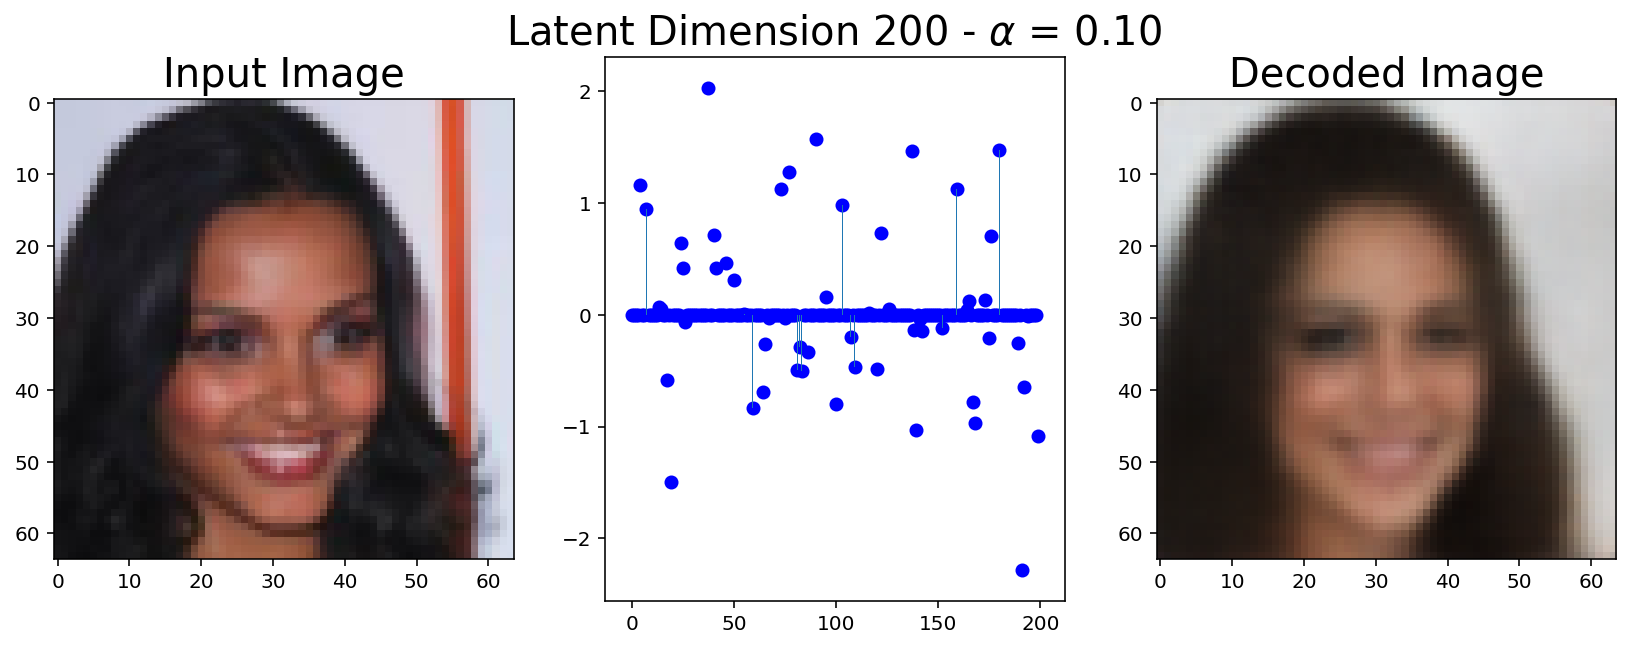

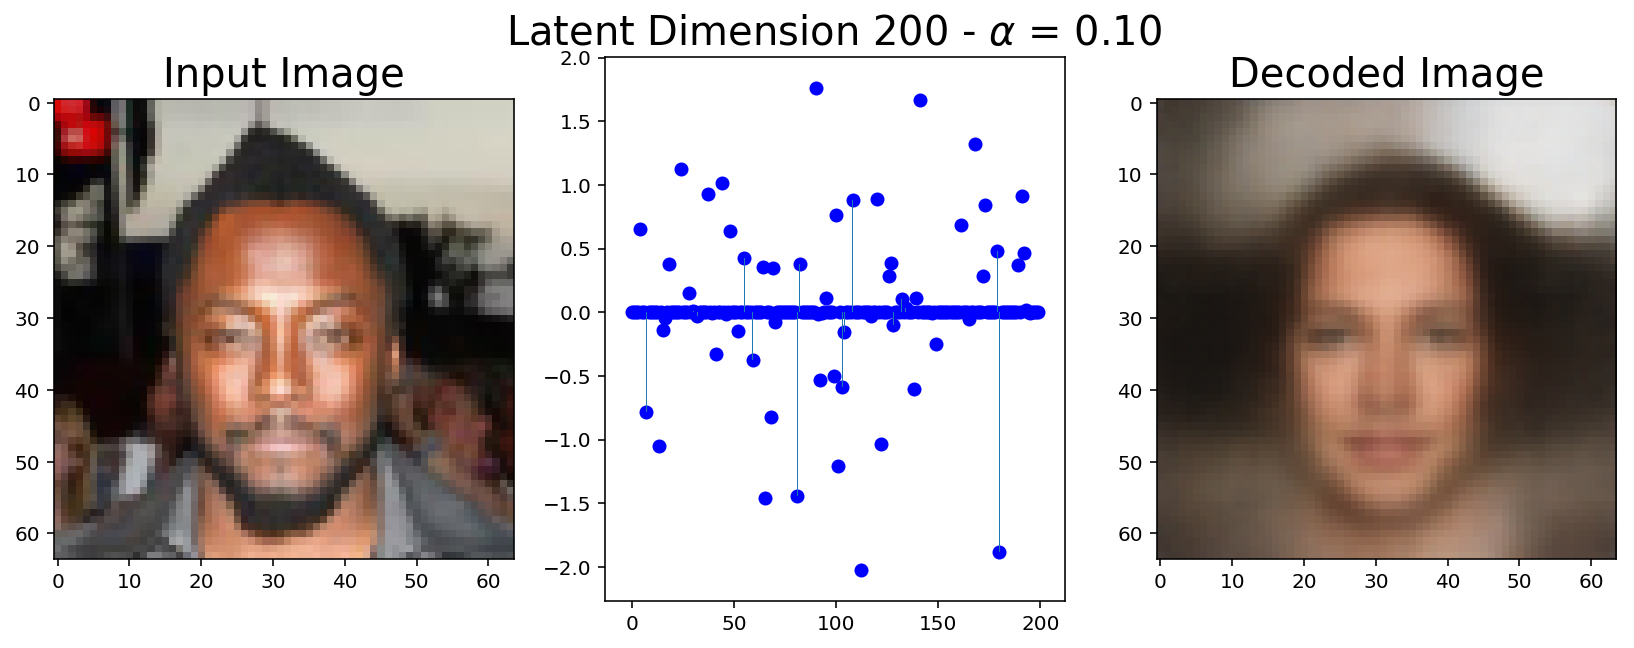

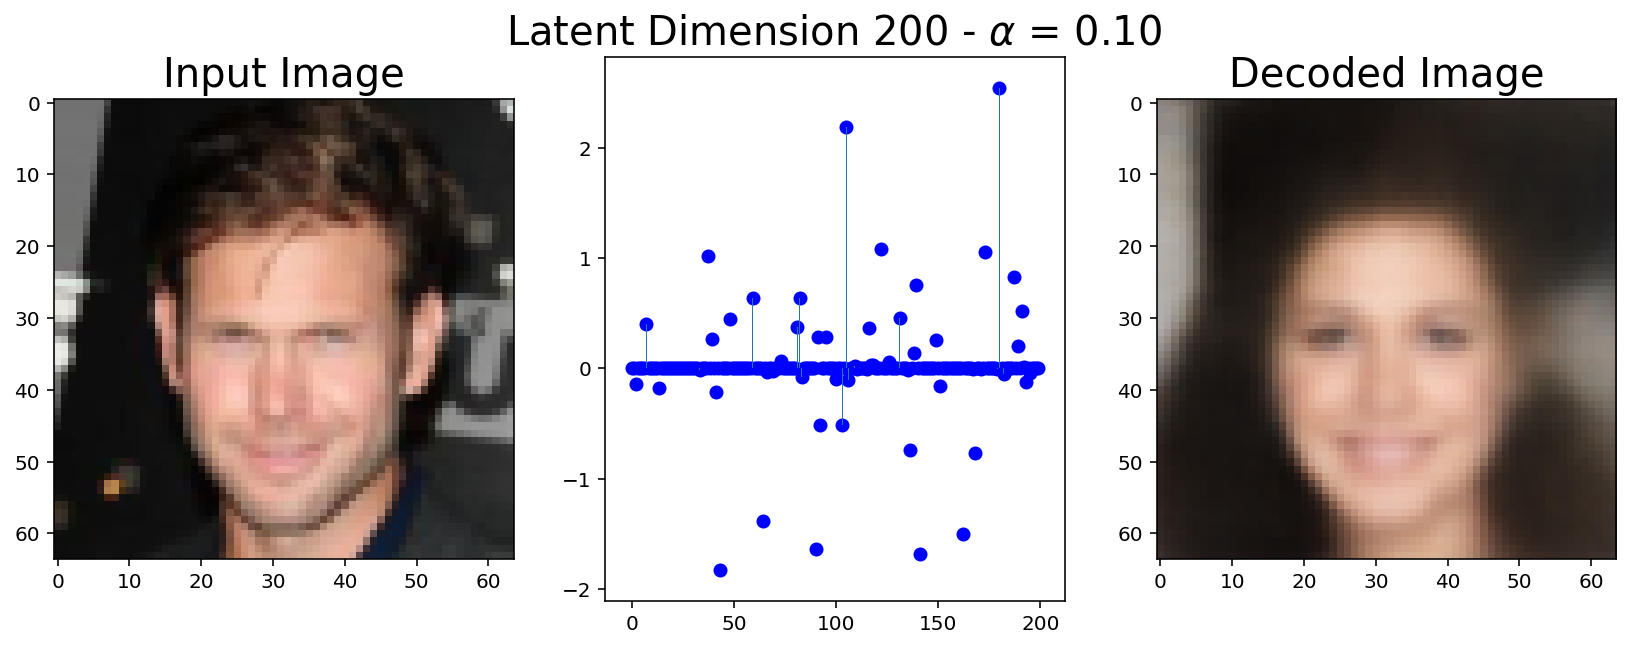

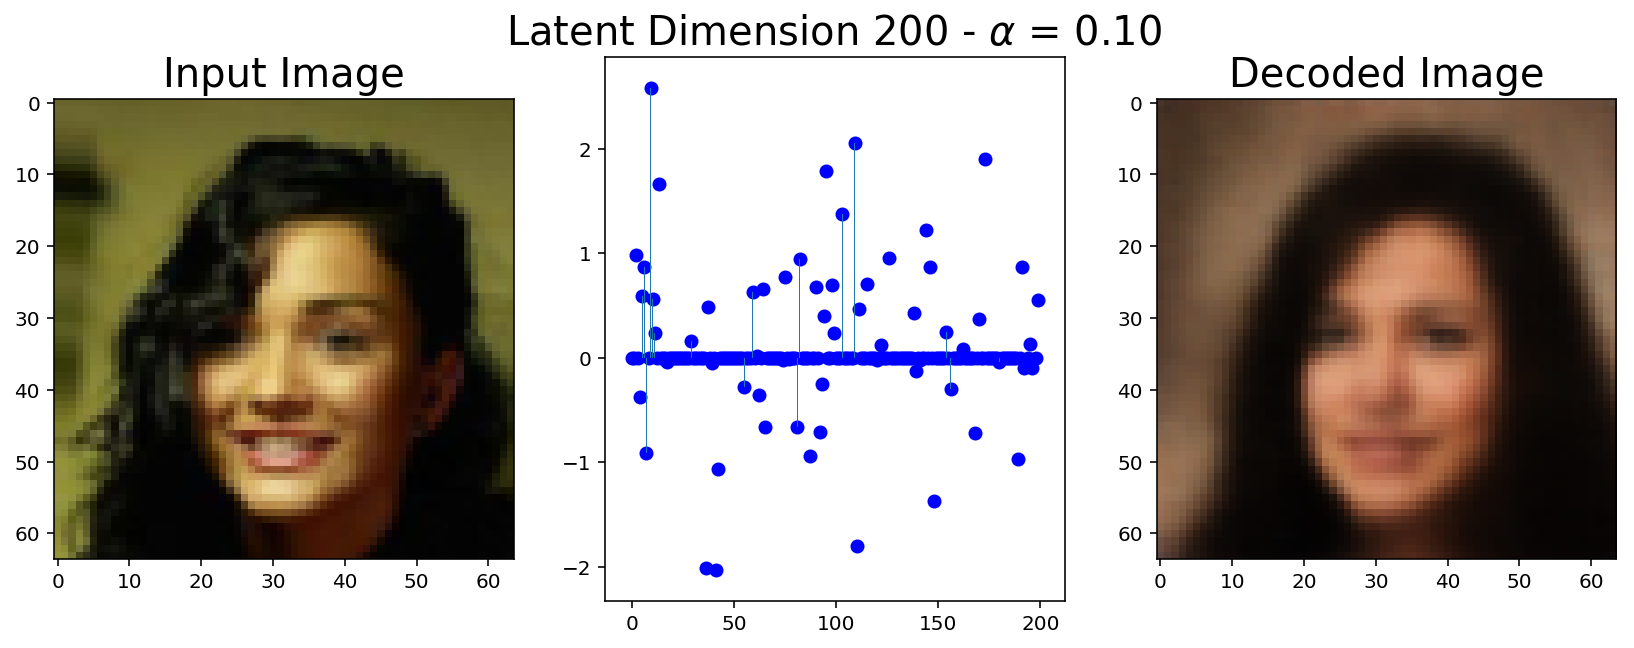

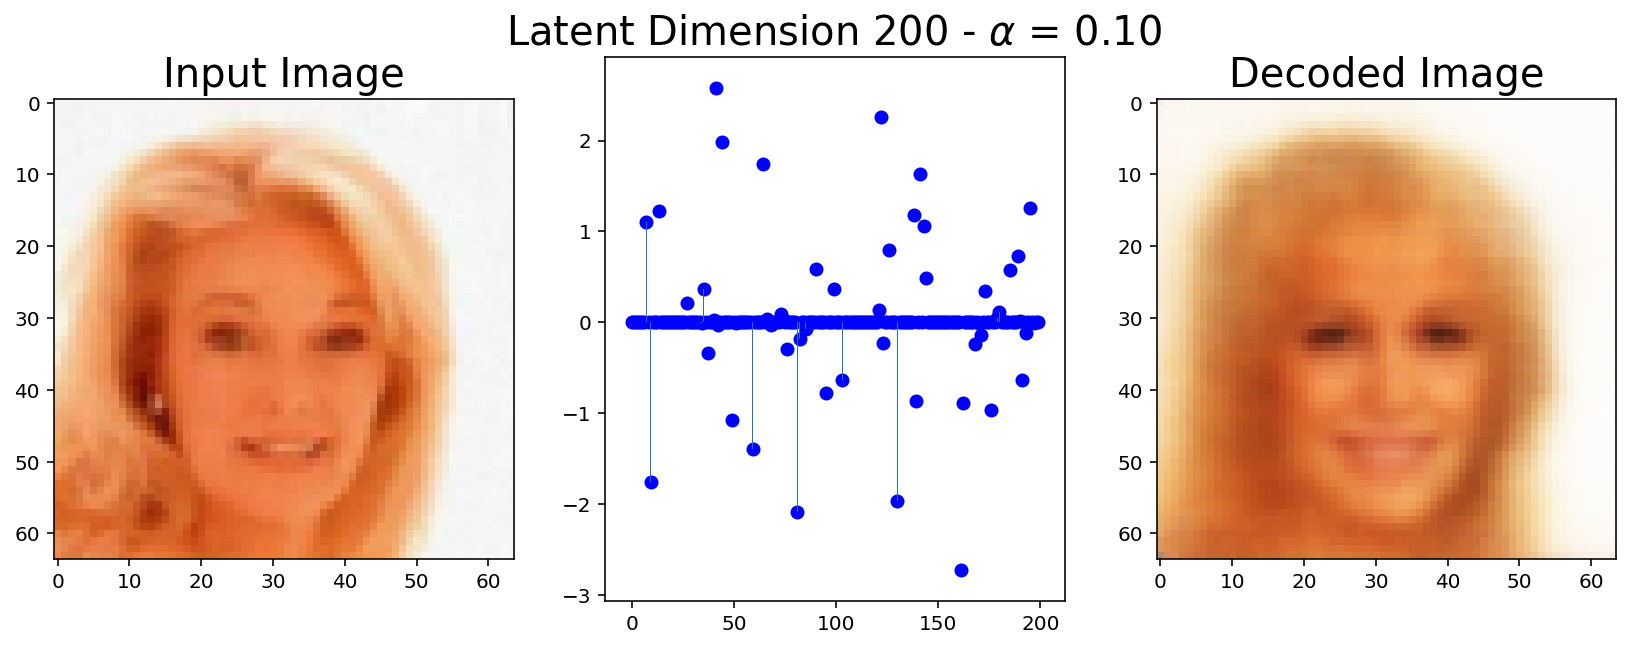

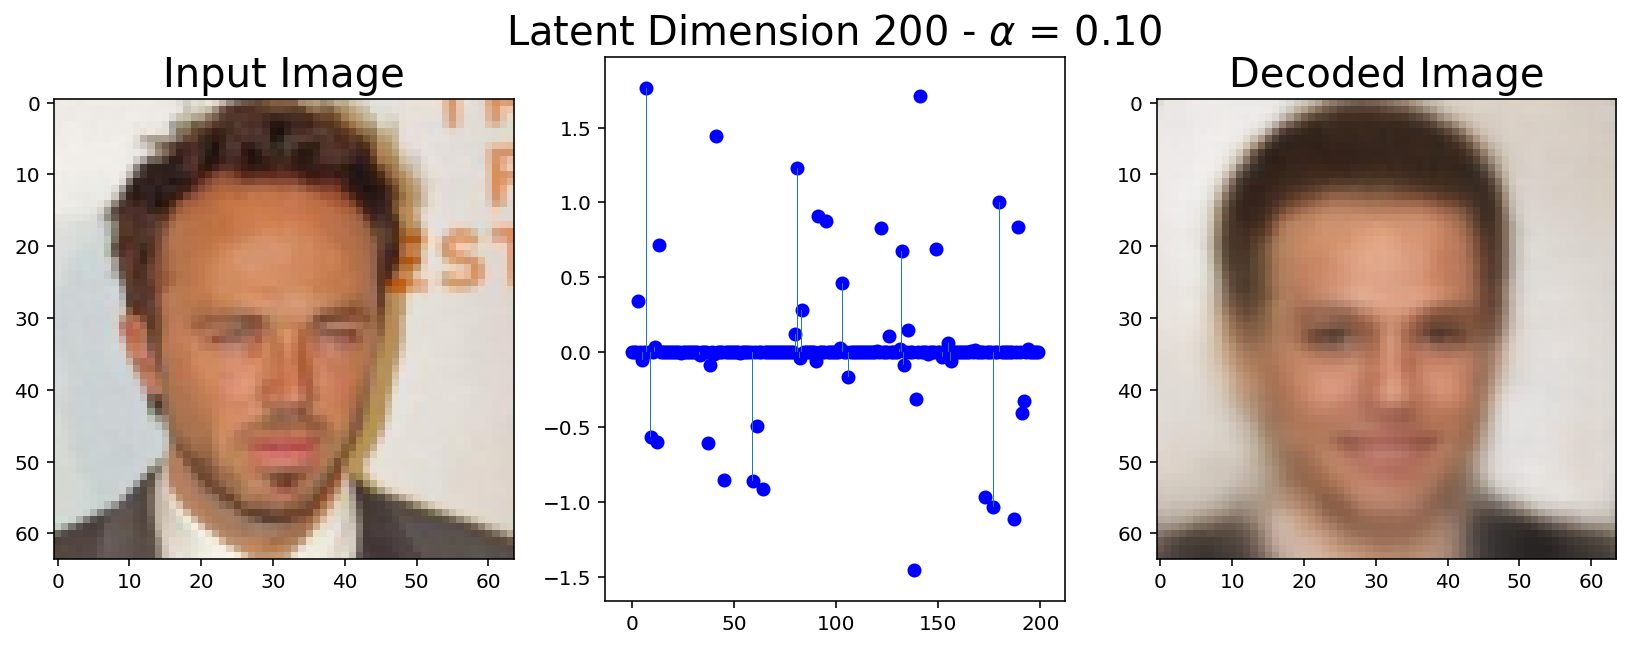

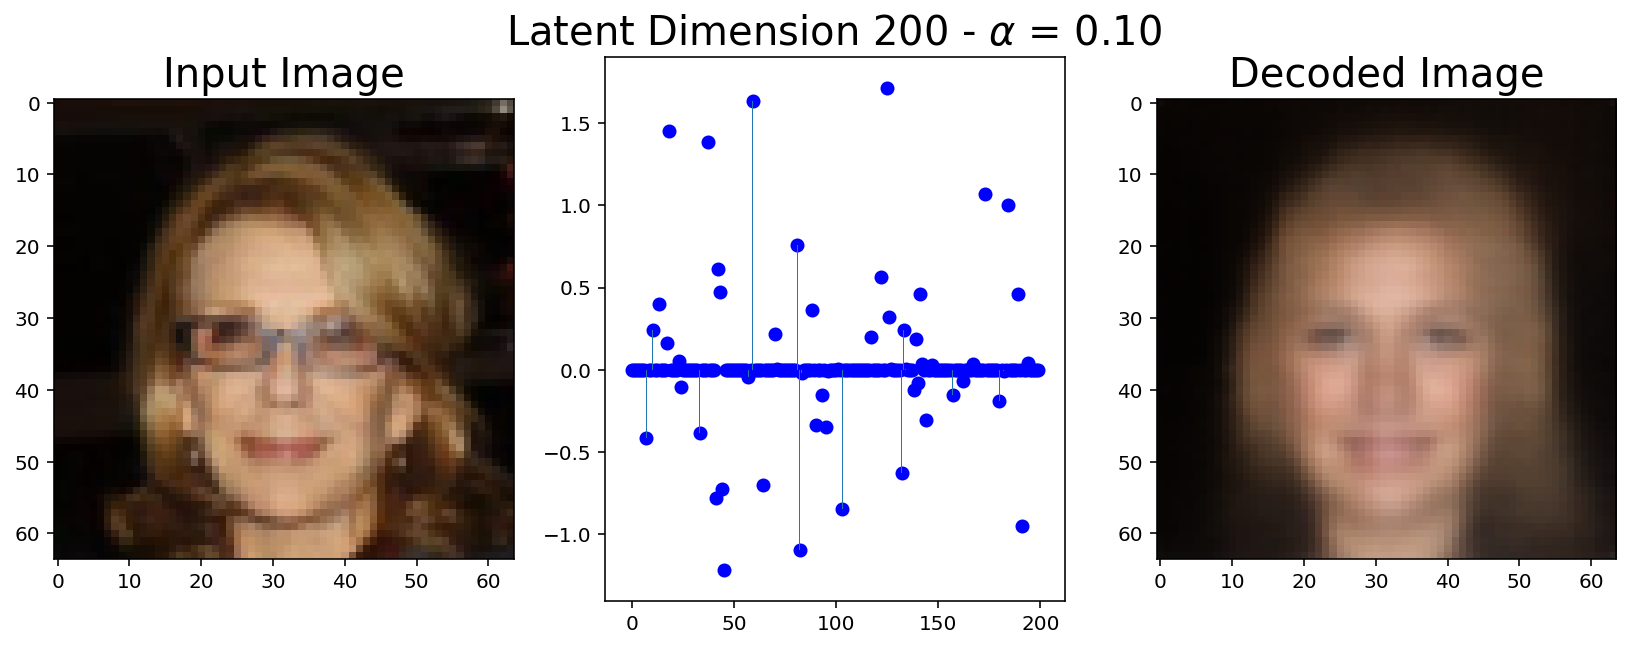

In [21]:
for i in range(0, 15):
    plot_encoding(images[i][None,:], convvsc, 
                  model_params['latent_sz'], 
                  model_params['alpha'])

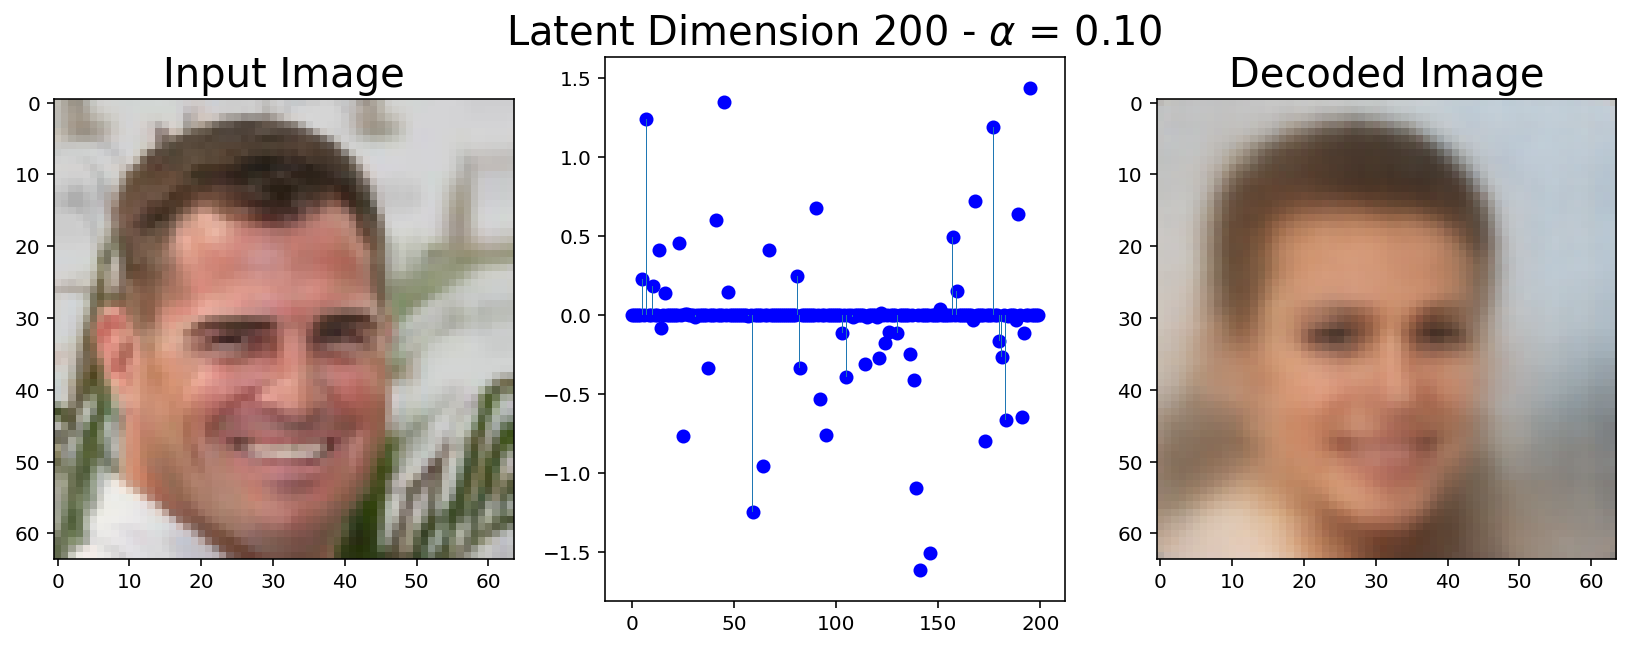

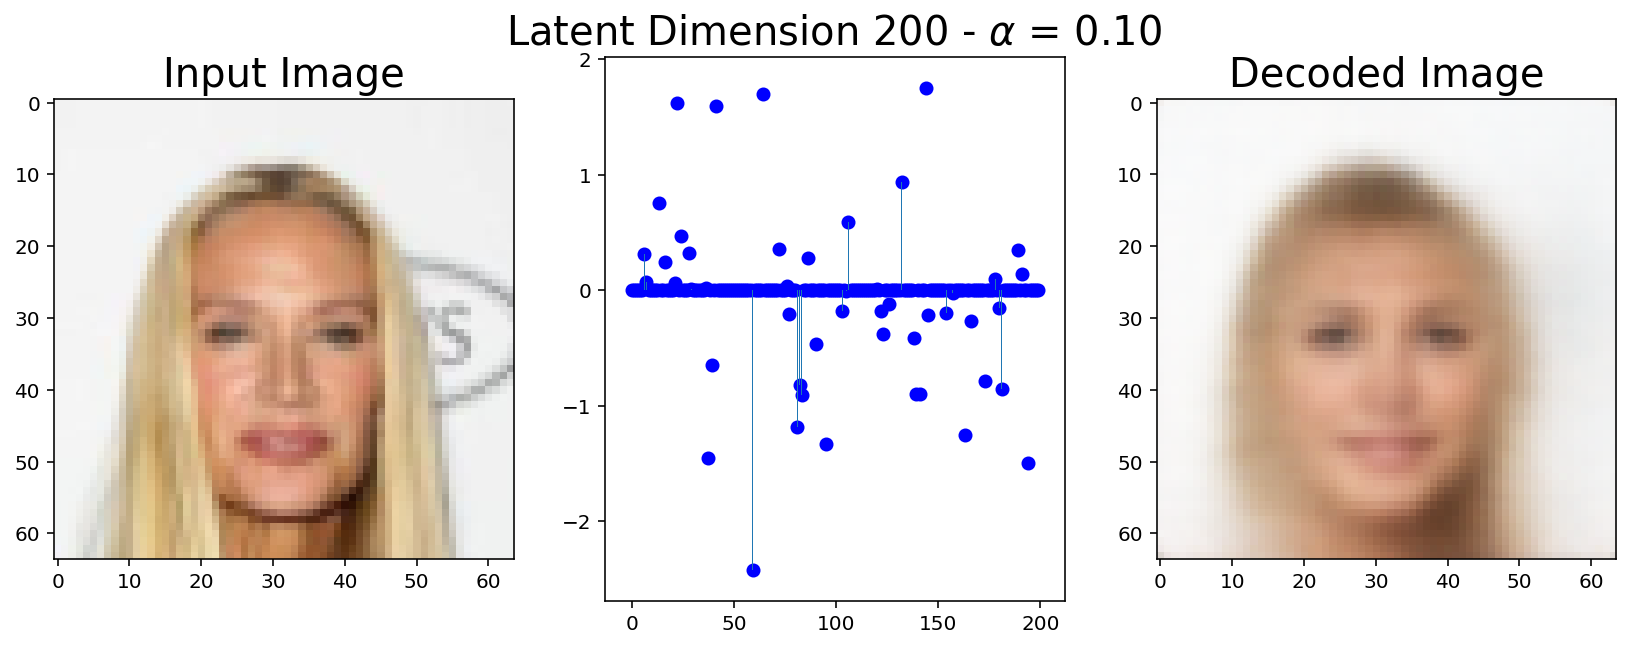

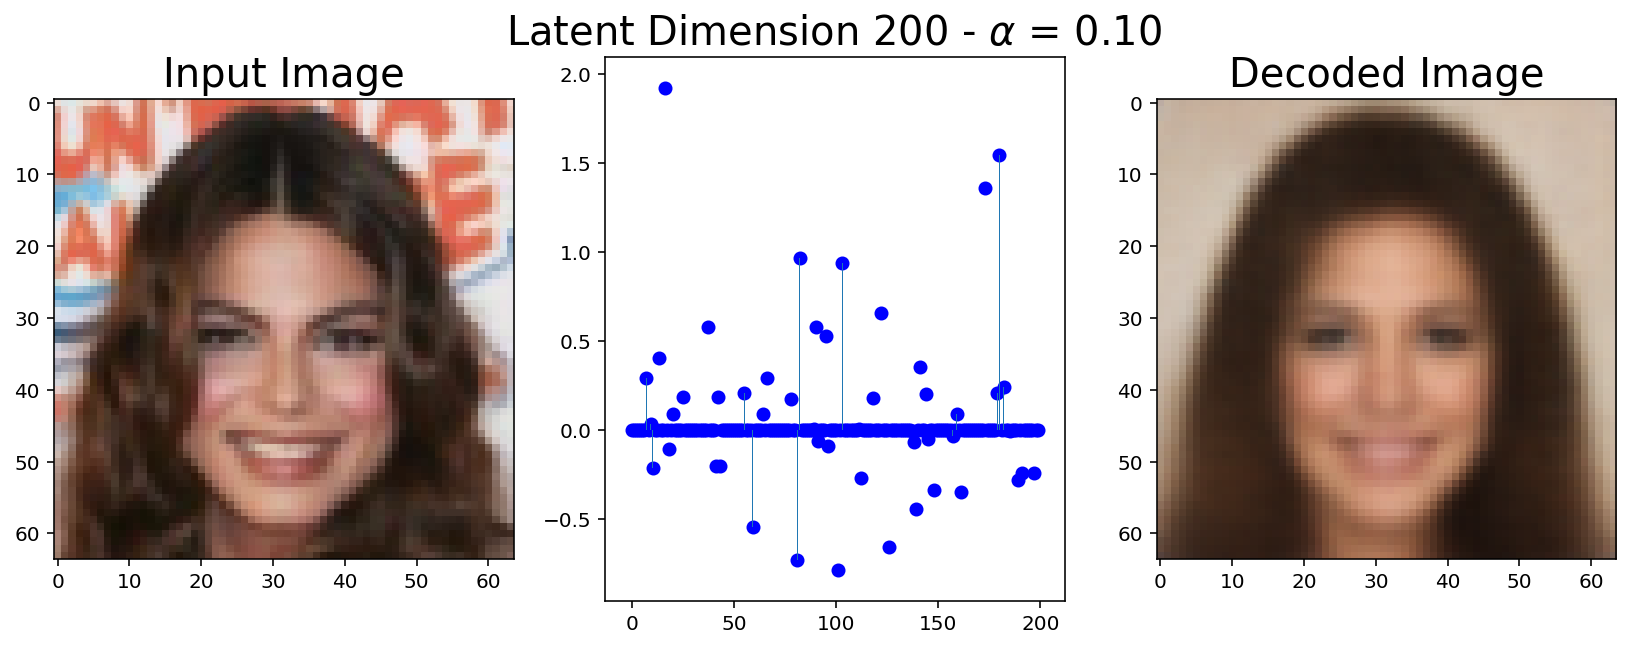

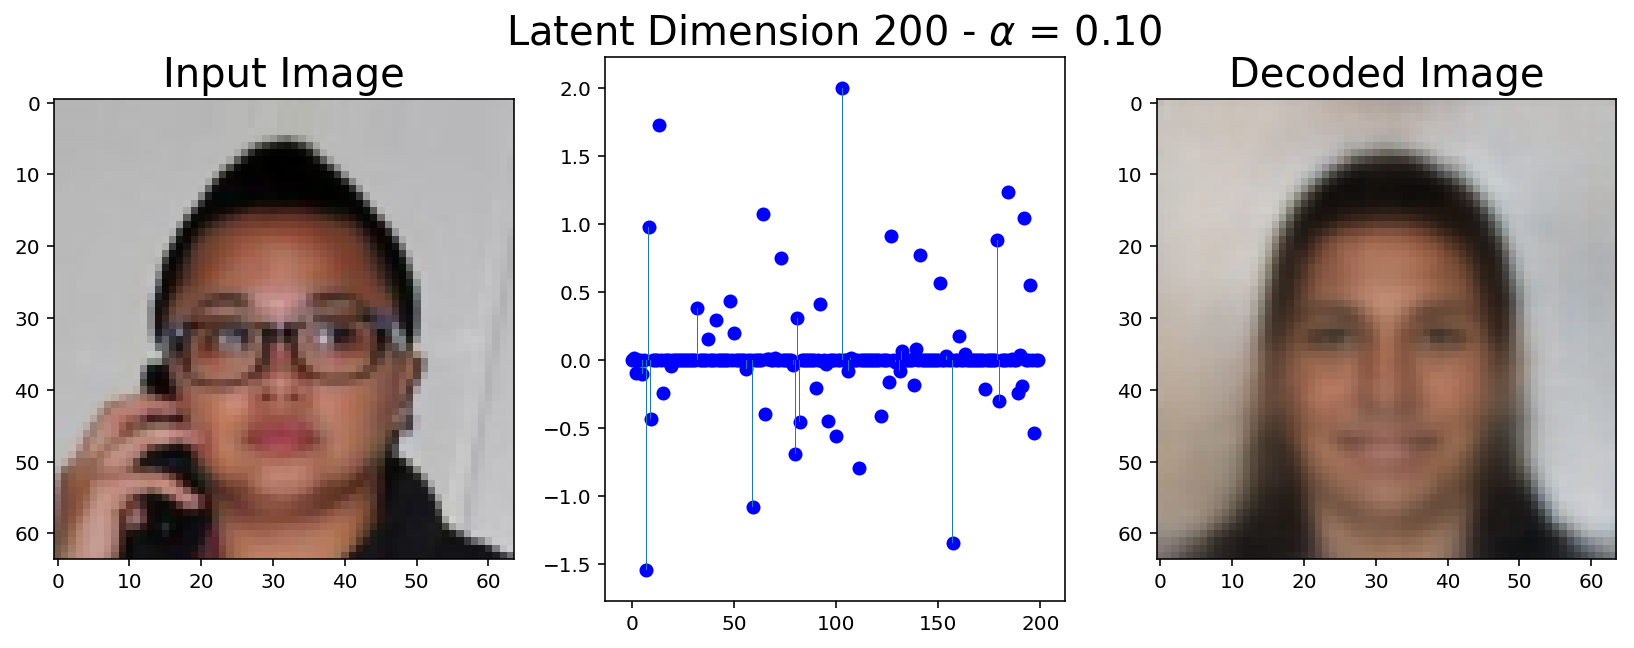

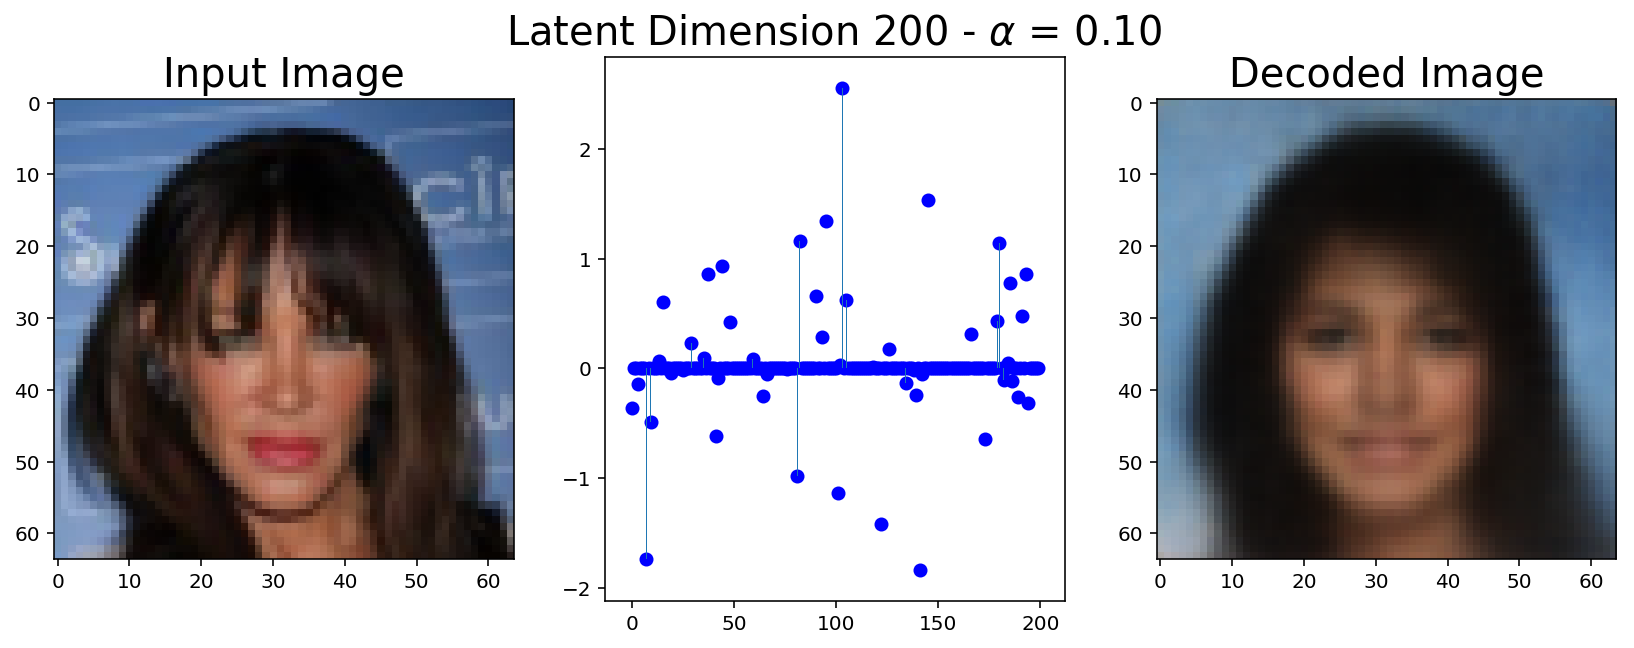

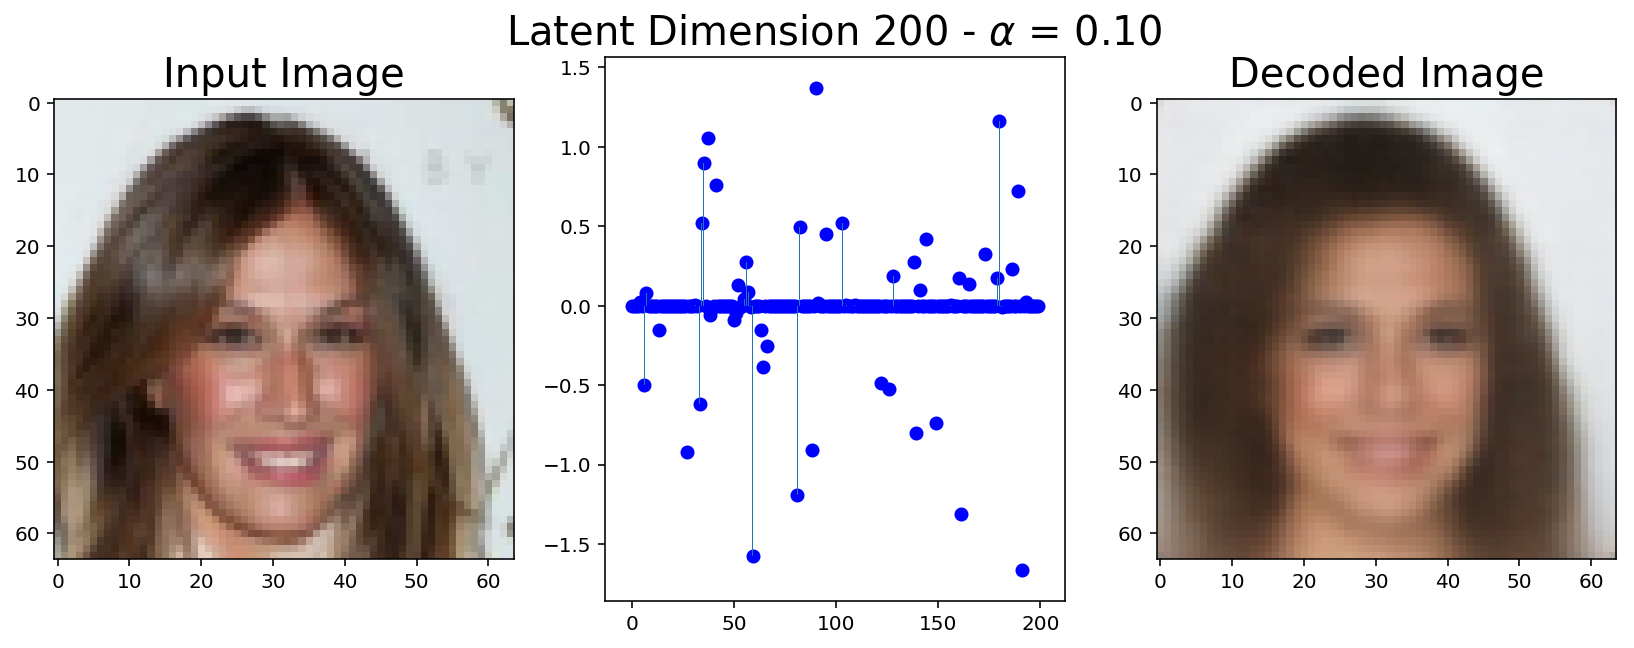

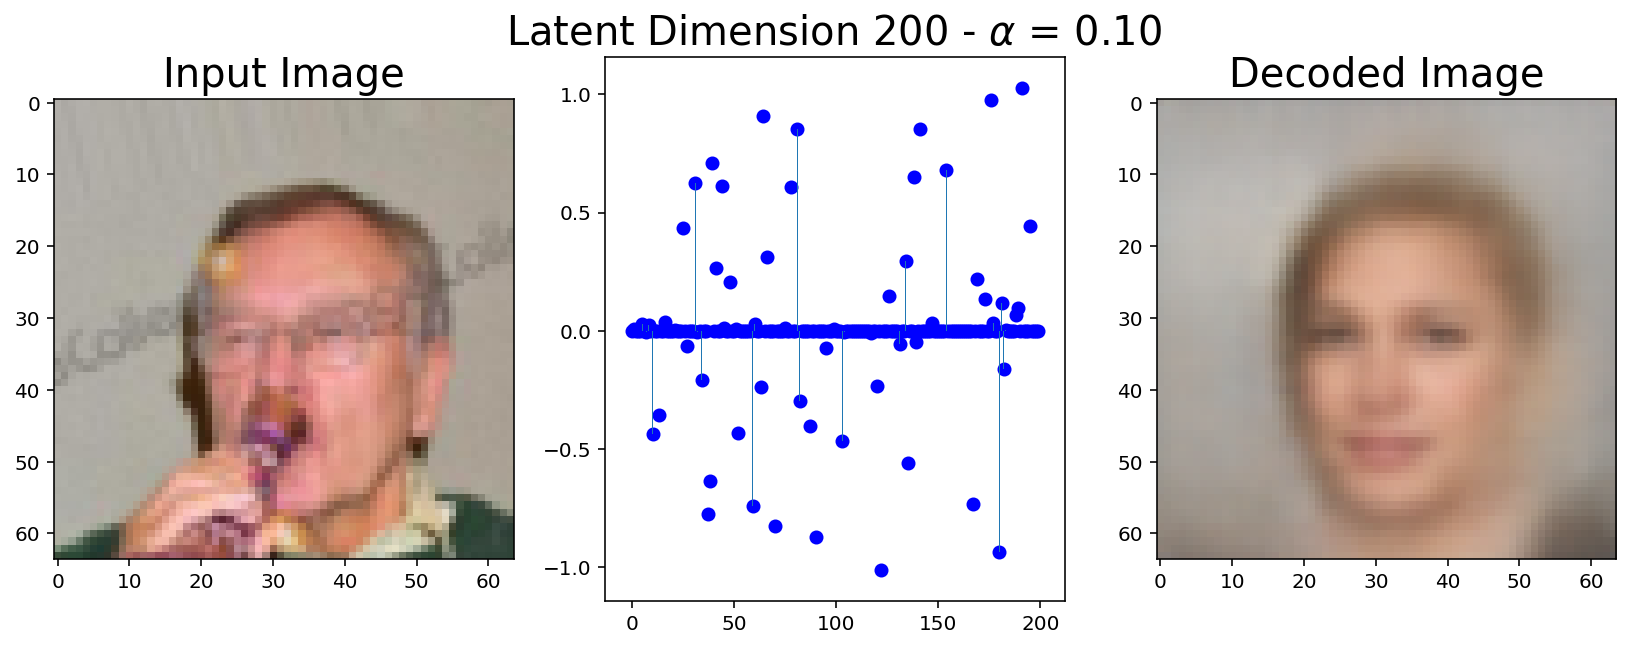

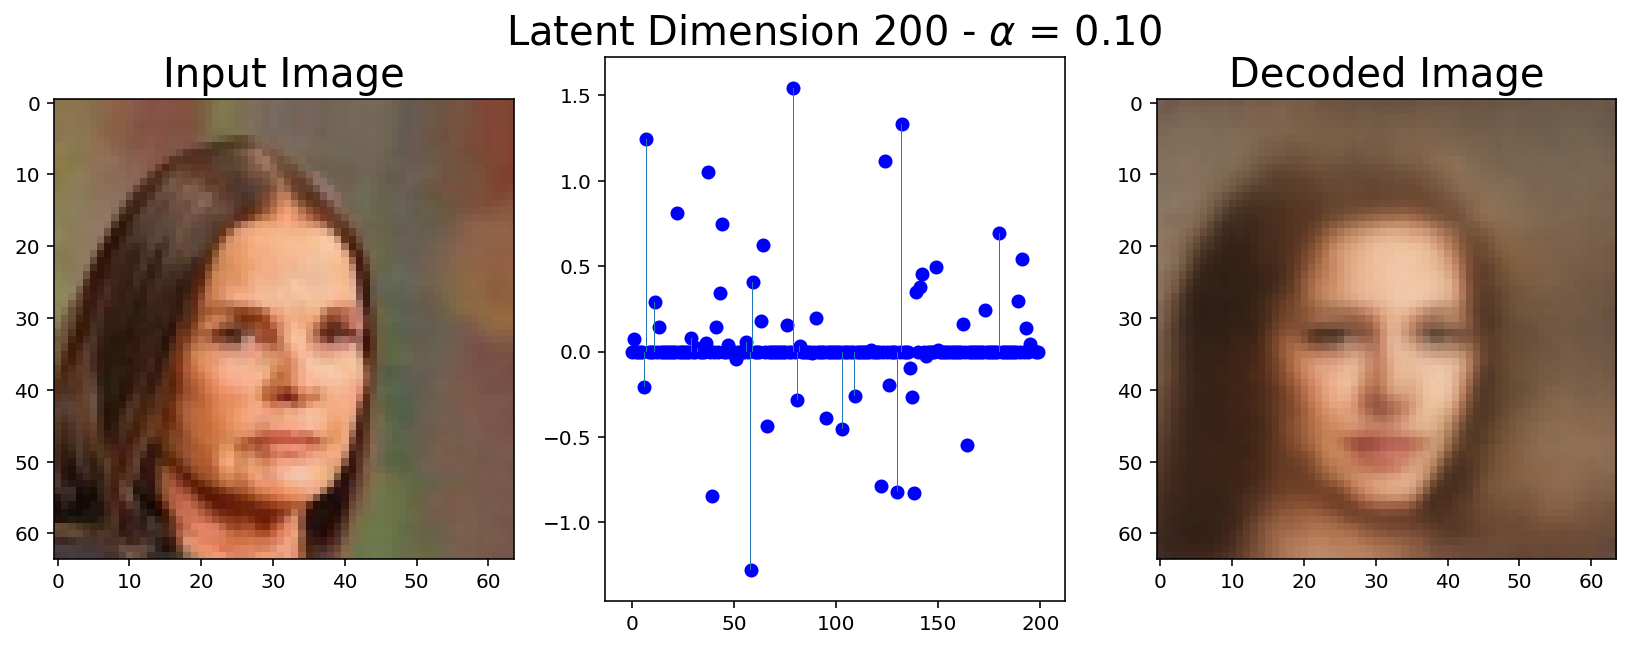

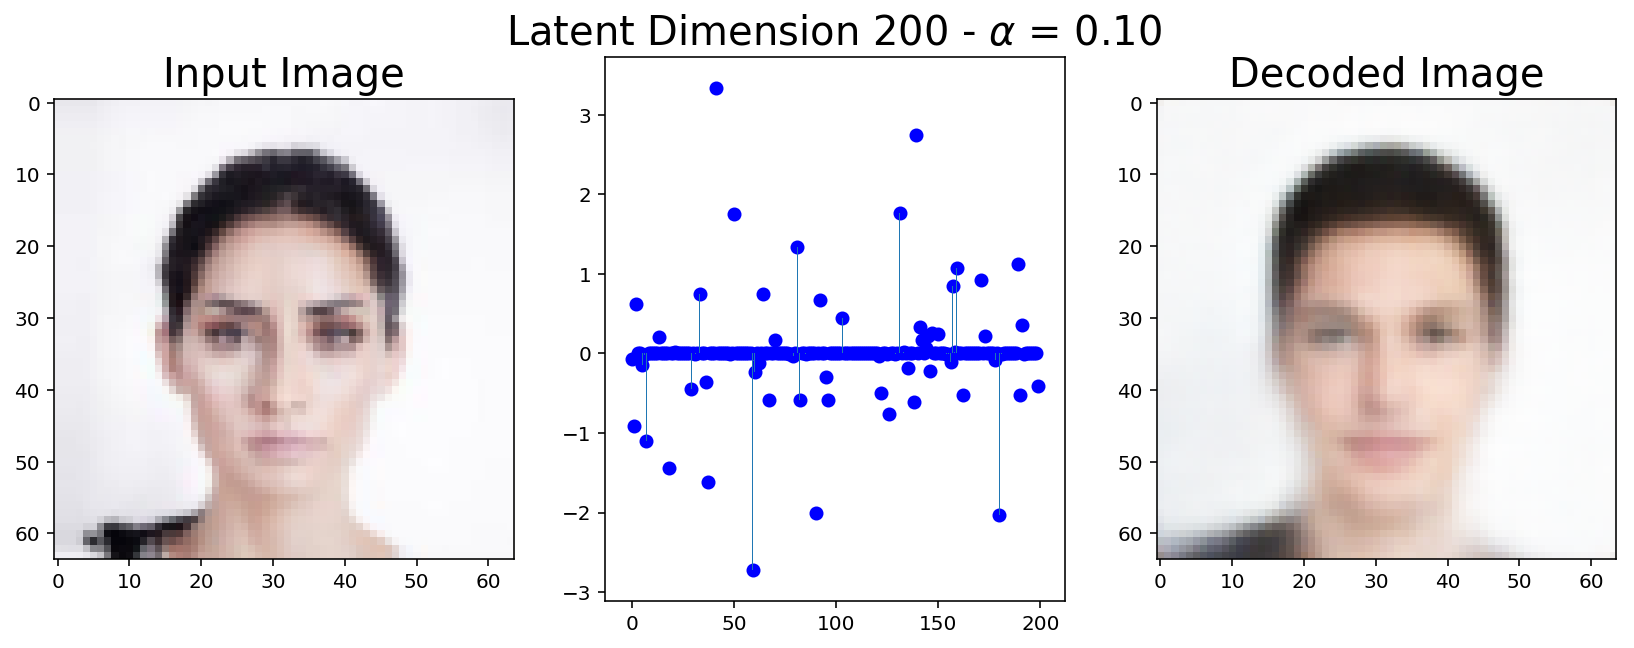

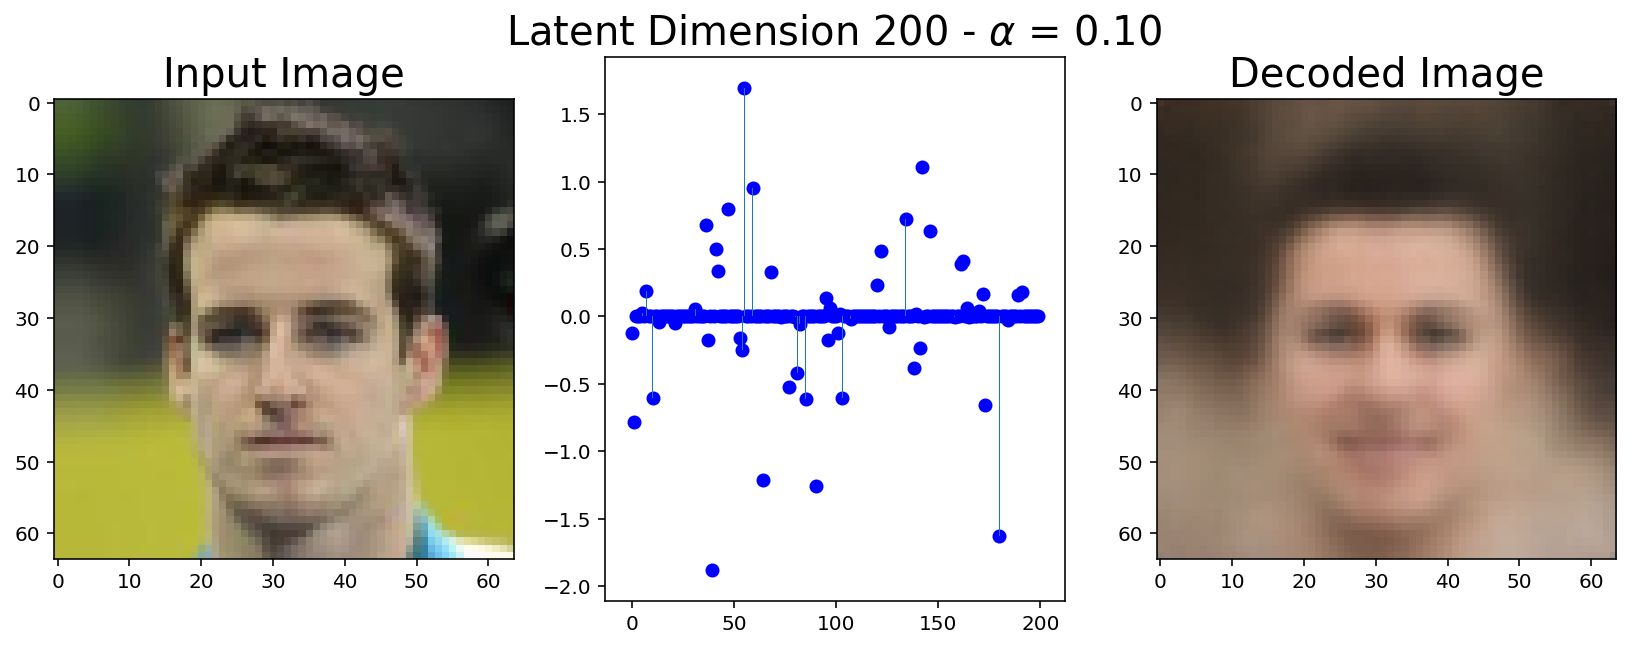

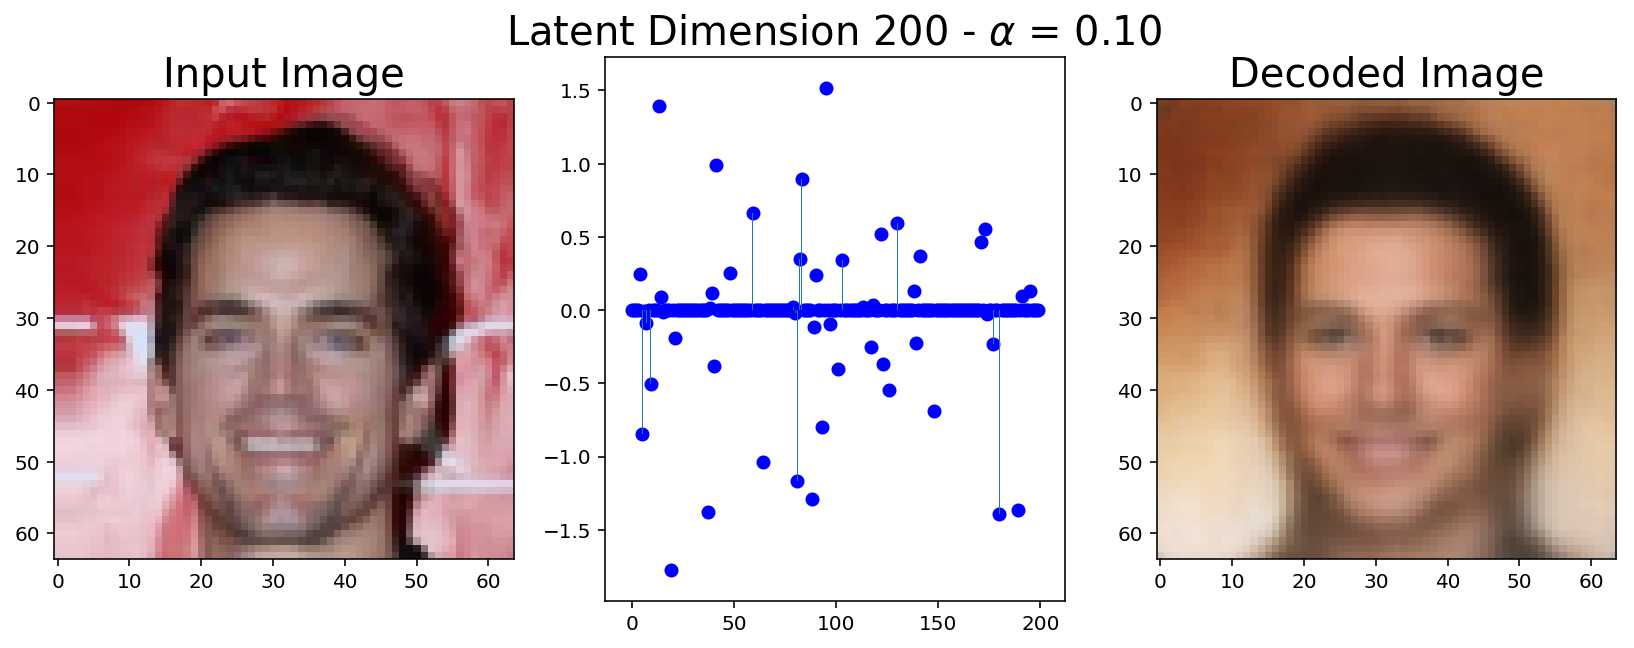

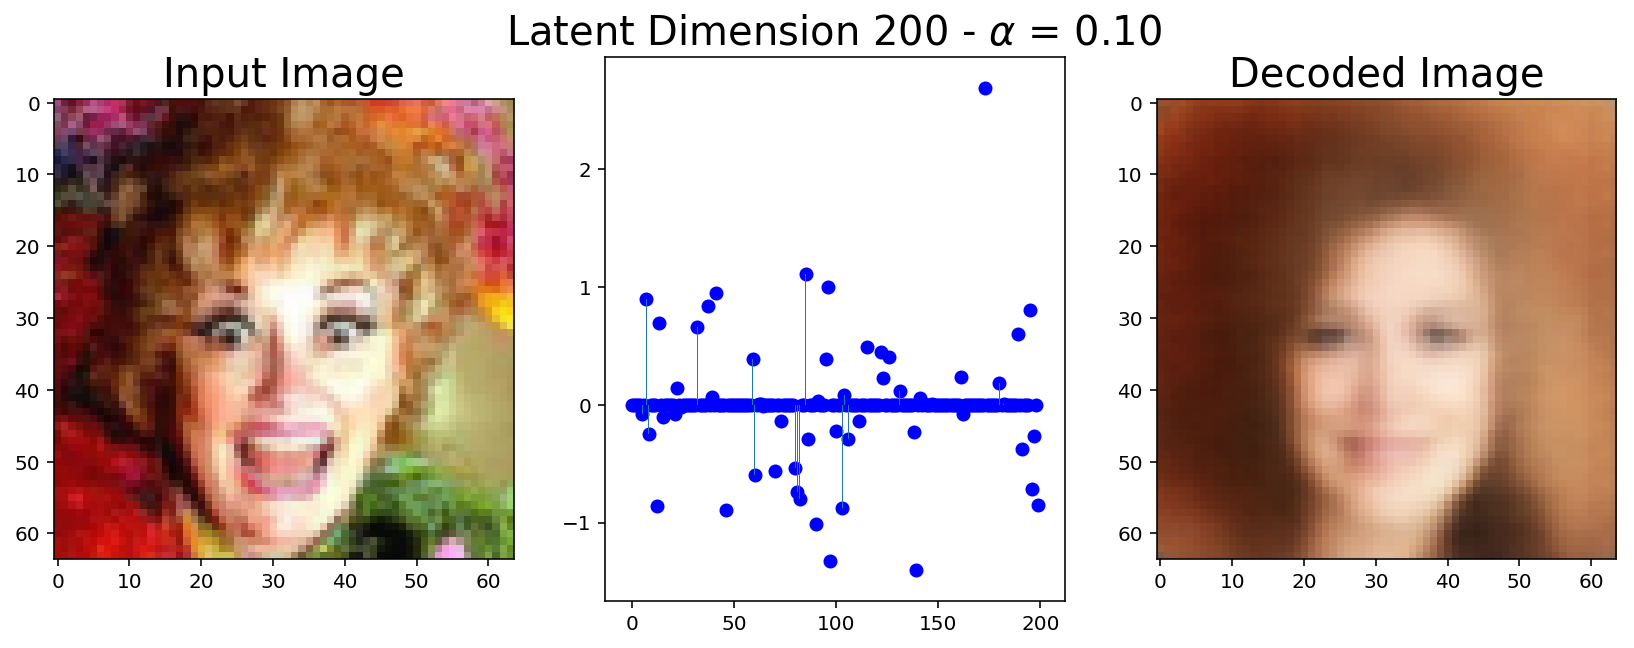

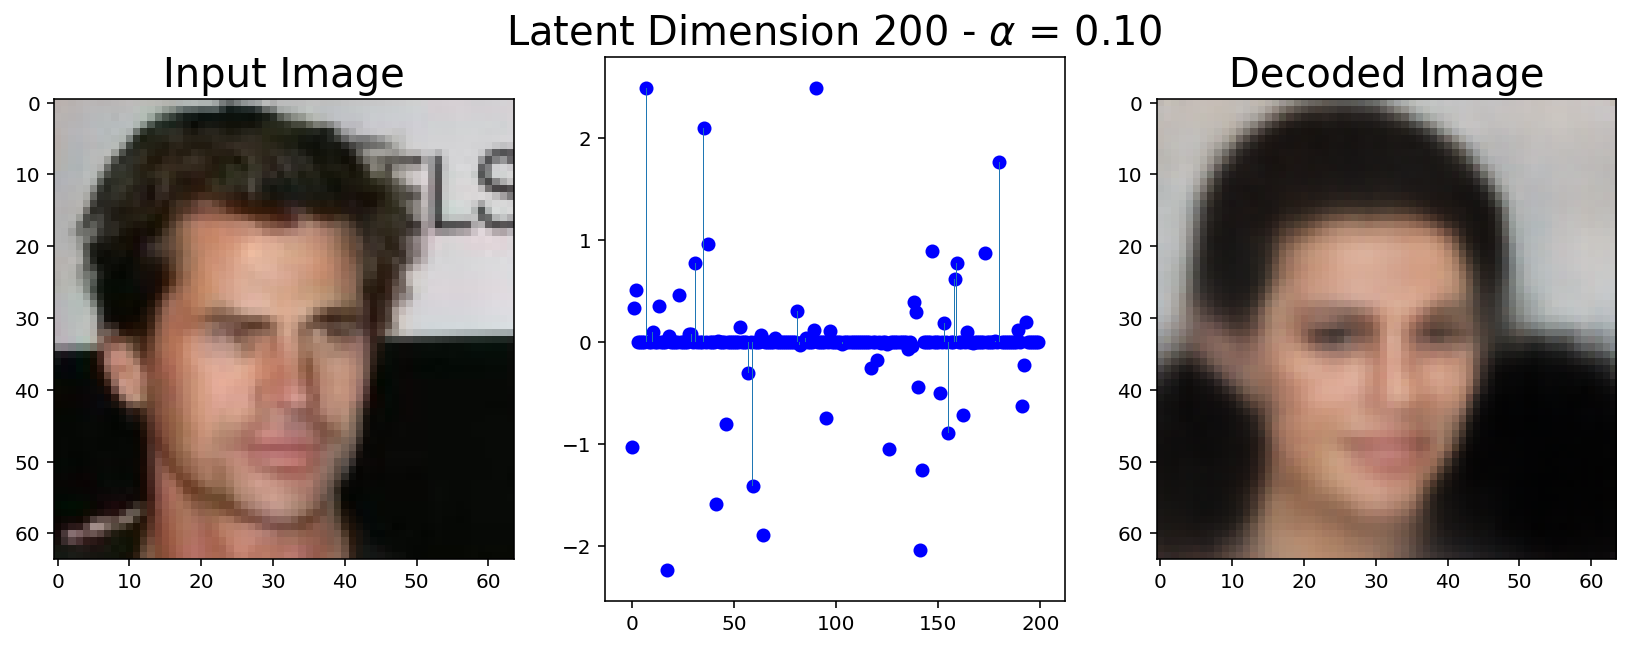

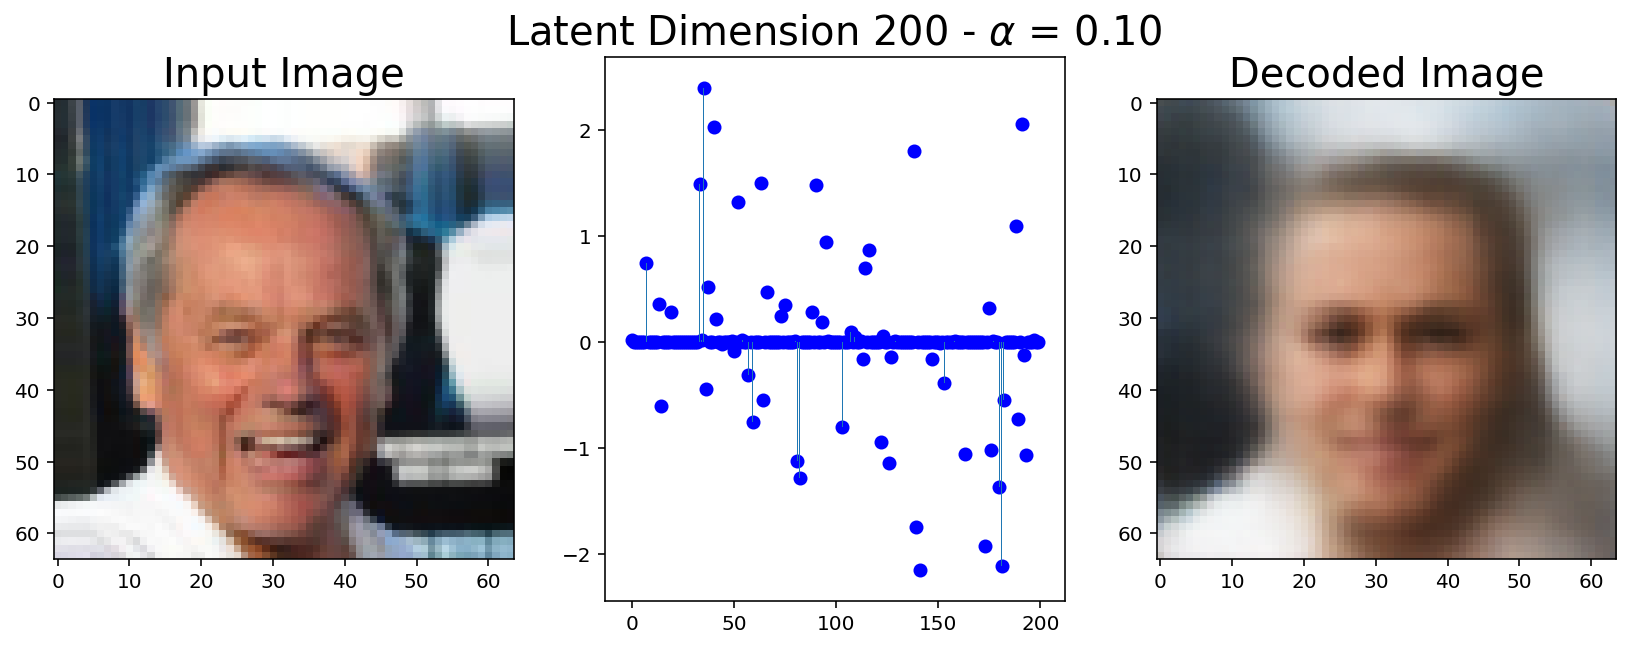

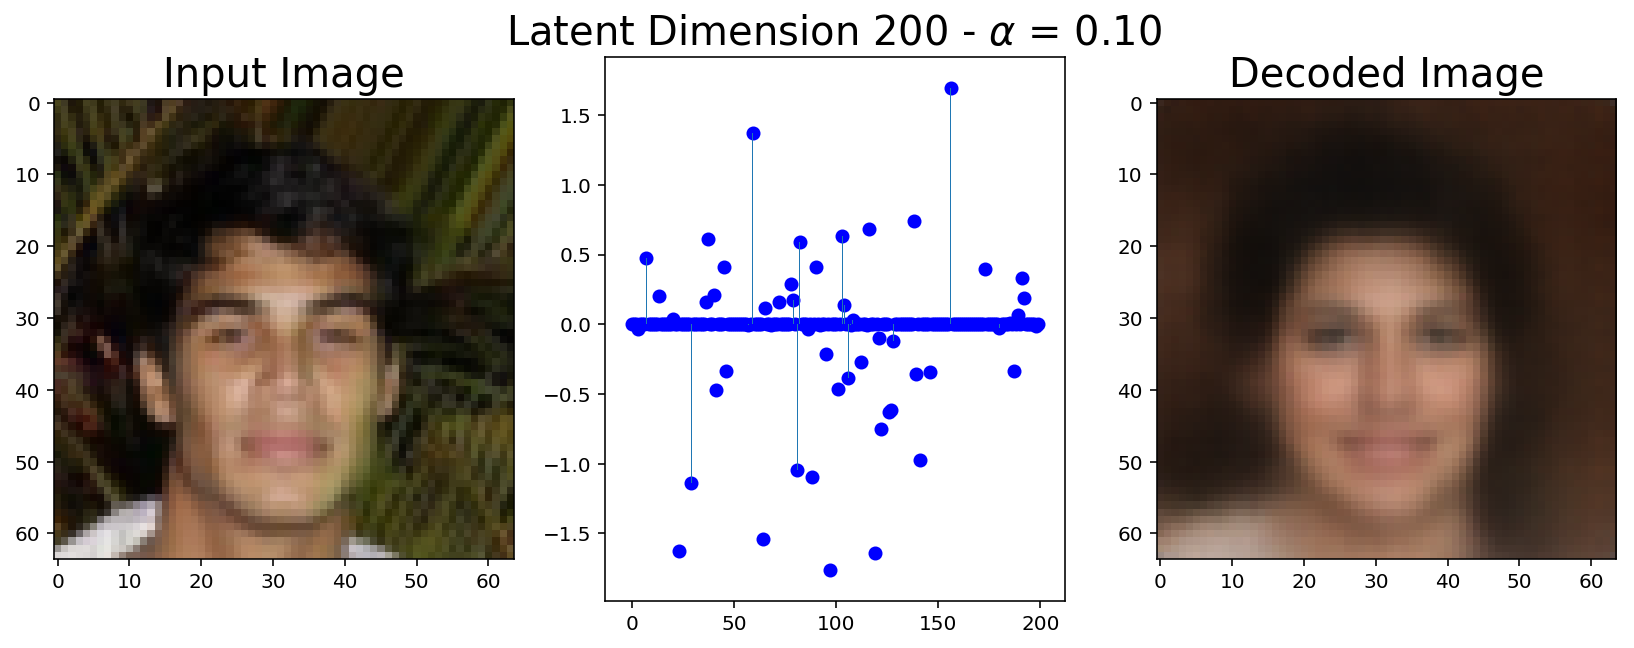

In [15]:
for i in range(15, 30):
    plot_encoding(images[i][None,:], convvsc, 
                  model_params['latent_sz'], 
                  model_params['alpha'])

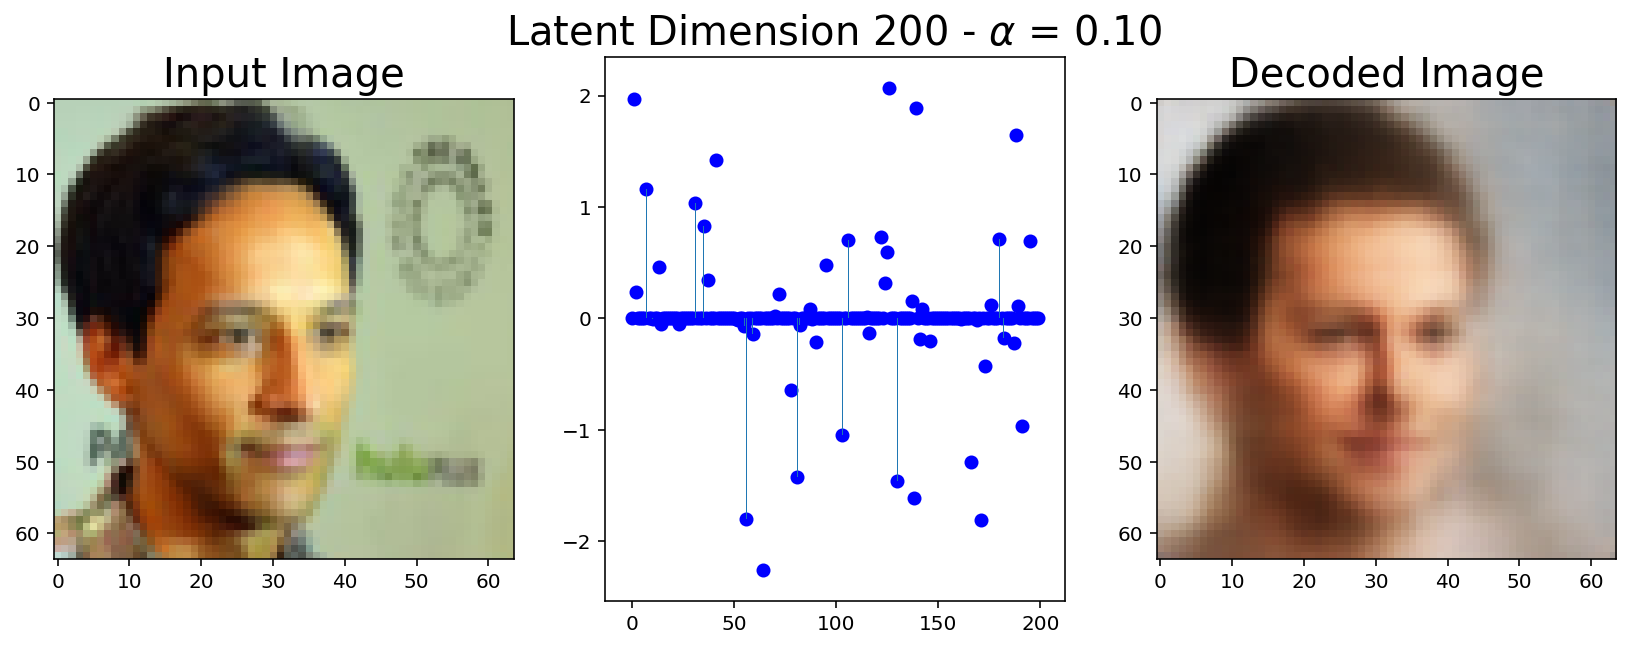

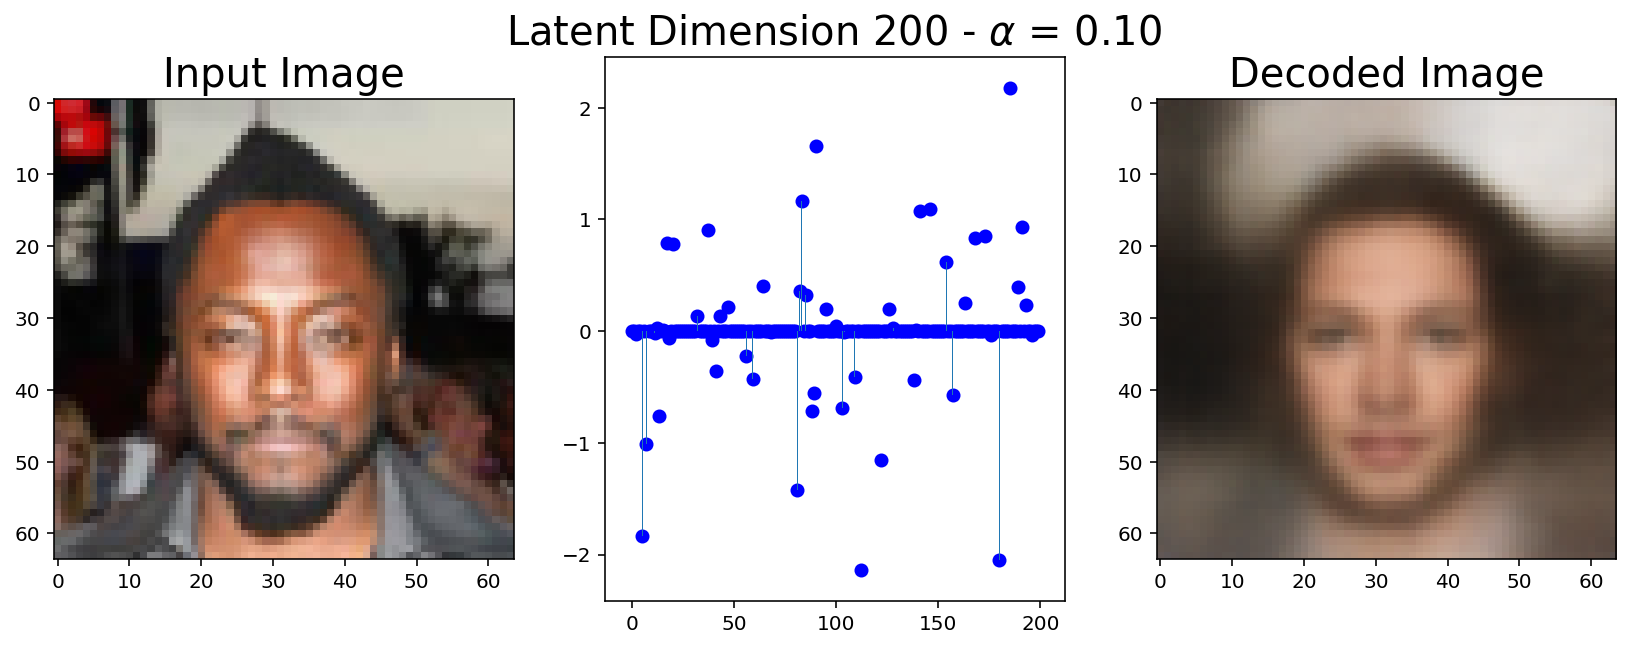

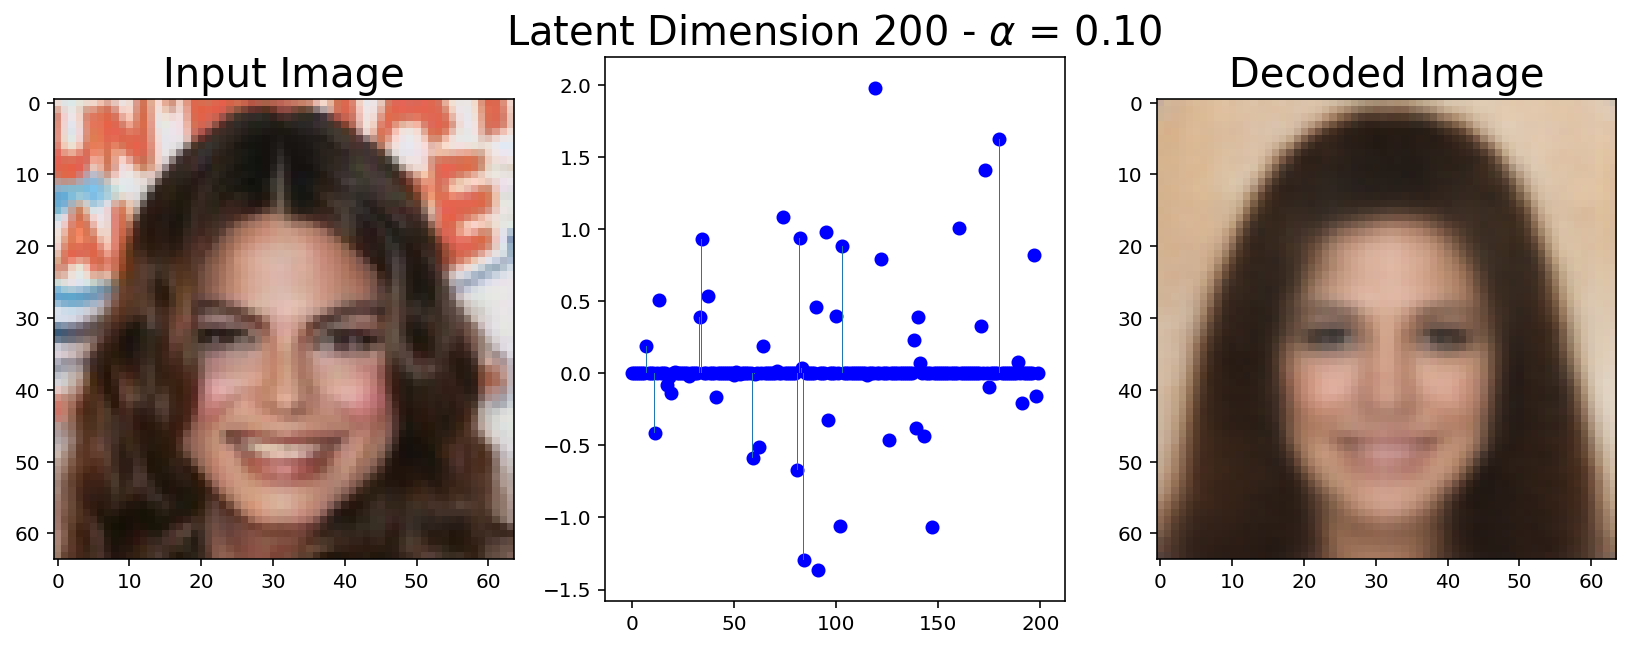

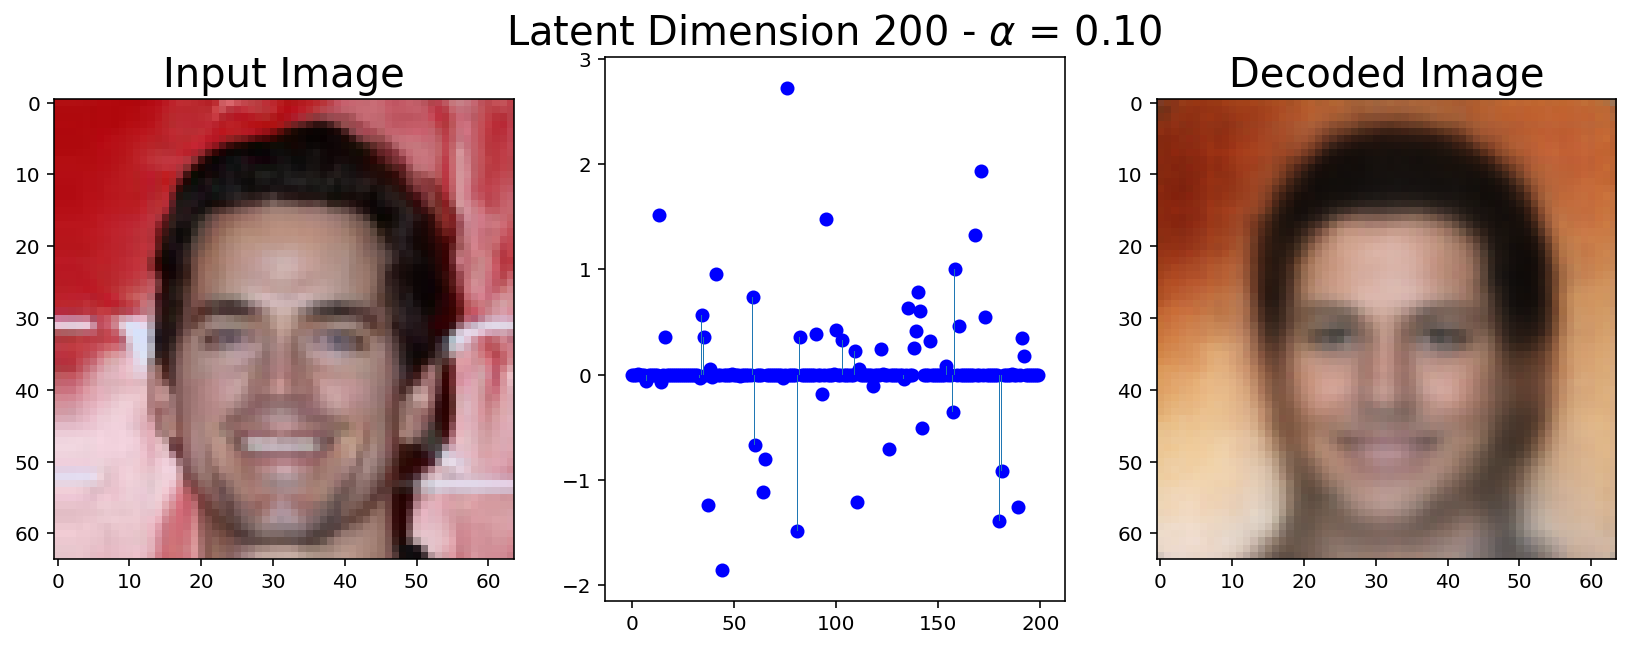

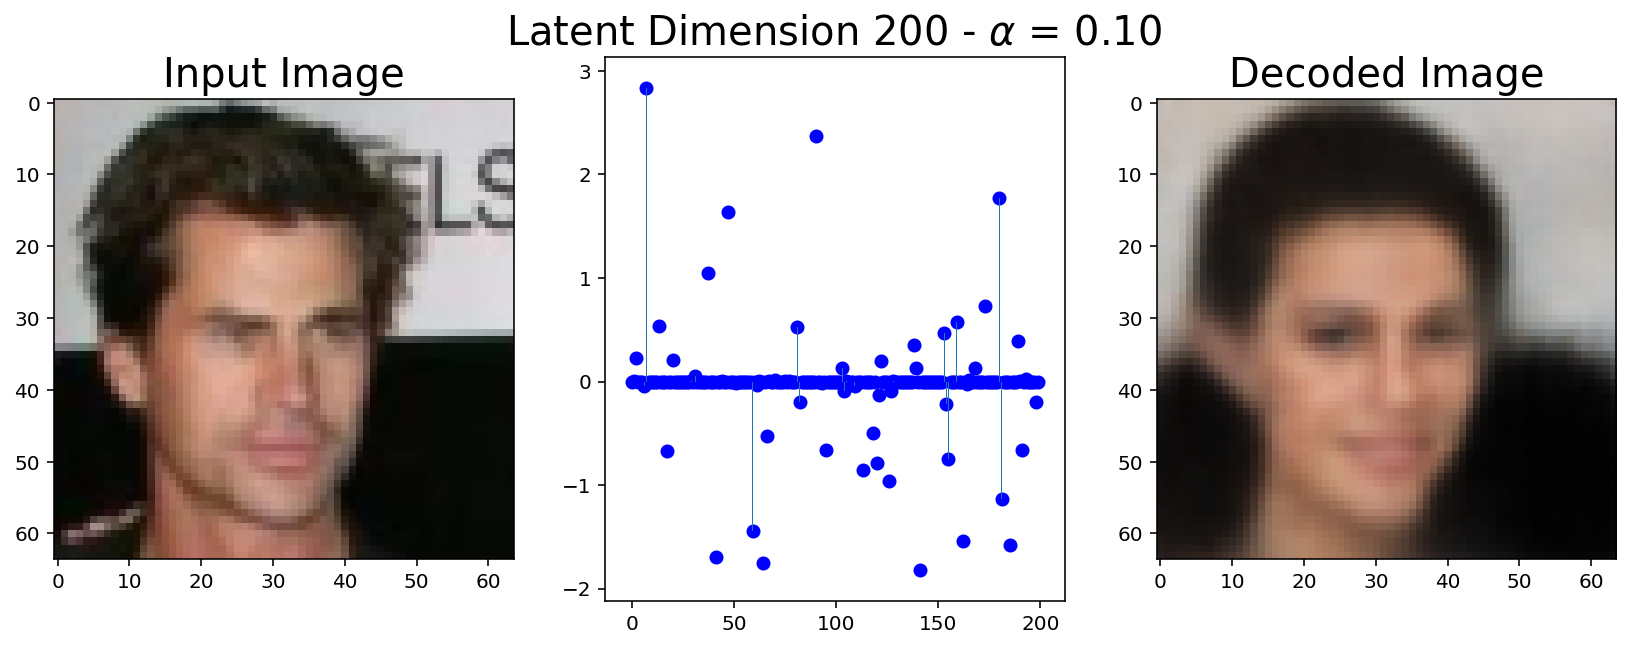

In [17]:
for i in [3, 9, 17, 25, 27]:
    plot_encoding(images[i][None,:], convvsc, 
                  model_params['latent_sz'], 
                  model_params['alpha'])

In [97]:
import random

def plot_horizontal_traversal(image, vsc, latent_sz, length, 
                              delta, threshold=1e-4, plot_all=False, 
                              plot_list=None, width=1/4, n_indices=15):
    image = vsc.transform(image).to(vsc.device)
    decoded, mu, logvar, logspike = vsc.model.forward(image)
    z = vsc.model.reparameterize(mu, logvar, logspike)
    img = vsc.inverse_transform(vsc.model.decode(z))
    z_ = z.cpu().detach().numpy()[0]
    
    plt.bar(np.arange(latent_sz), height=z_, width=width, align='center')
    plt.scatter(np.arange(latent_sz), z_, color='blue')
    plt.show()
    
    non_zero = [i for i in range(latent_sz) if np.abs(z_[i]) > threshold]
    inds = np.random.choice(non_zero, n_indices)
    print(inds)
    
    if not plot_all:
        non_zero = inds # [ind]
    if plot_list:
        non_zero = plot_list
        
    print(non_zero)
    
    hor_traversal = []
    for ind in non_zero:
        images = []
        z1 = z.clone()
        for i in range(length):
            img = to_numpy(vsc.model.decode(z1), vsc)
            img = np.transpose(img, (1,2,0))
            img[:,0] = 1
            img[:,-1] = 1
            img[0,:] = 1
            img[-1,:] = 1
            images.append(img)
            z1[0, ind] = z1[0, ind] + delta if z[0,ind] < 0 else z1[0, ind] - delta

        hor_traversal.append(np.concatenate(images, axis=1))
    traversal = np.concatenate(hor_traversal, axis=0)
    plt.figure(figsize=(14,24))
    plt.axis('off')
    plt.imshow(traversal)
    plt.show()
#     return traversal

In [ ]:
dims = [59, 103, 173]

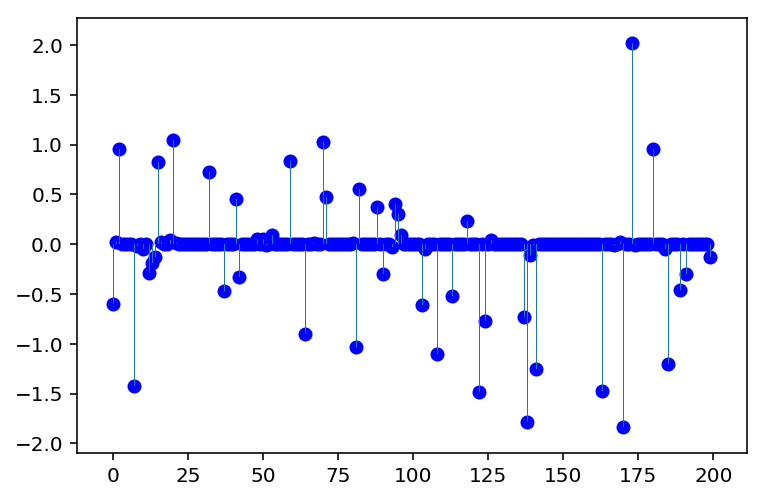

[ 20 124  81 185  94  82  37  14 185 103  82  64 141  90 185  13 113 173
  95]
[59, 103, 173]


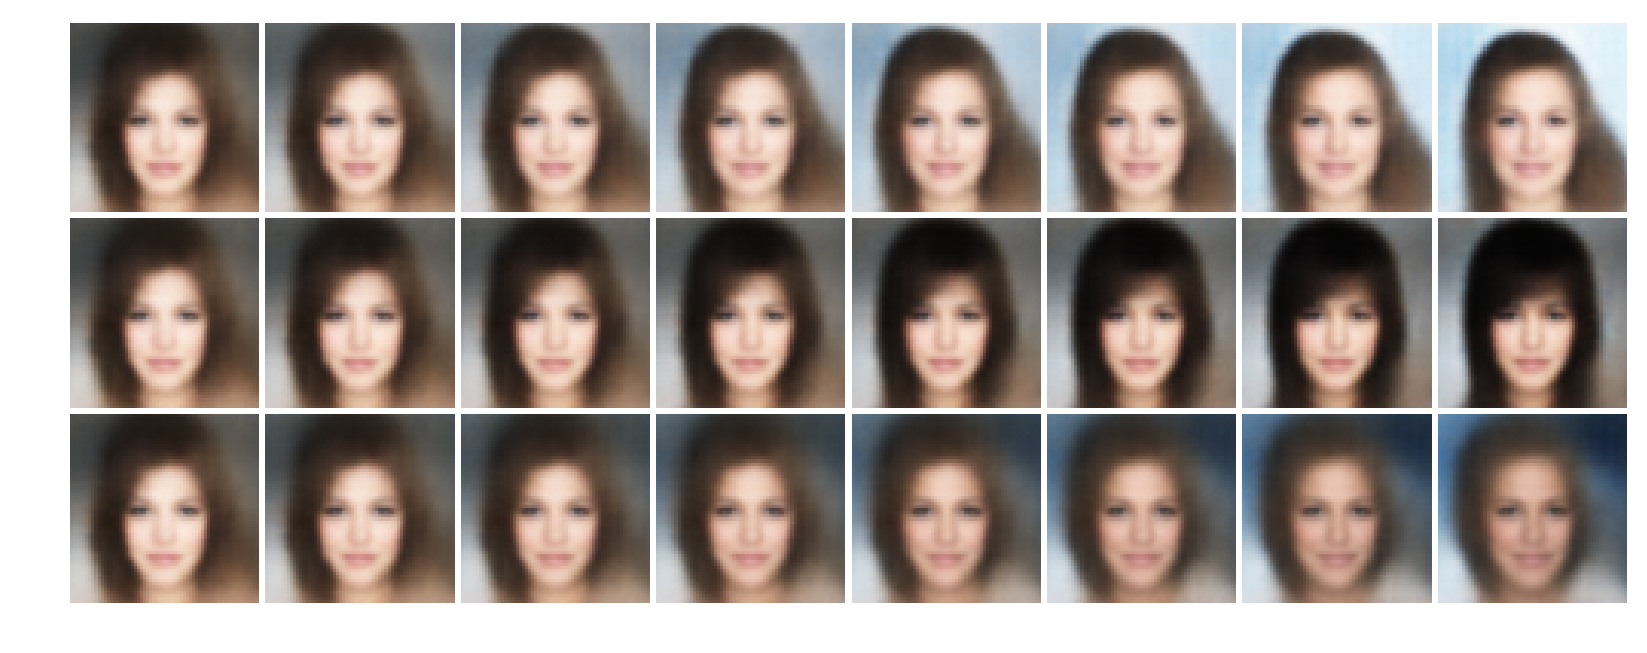

In [24]:
# 9 epochs
plot_horizontal_traversal(images[1][None,:], convvsc, 
                          model_params['latent_sz'], length=8, 
                          delta=0.5, threshold=0.1,
                          plot_all=False, 
                          plot_list=[59, 103, 173],
                          n_indices=19)

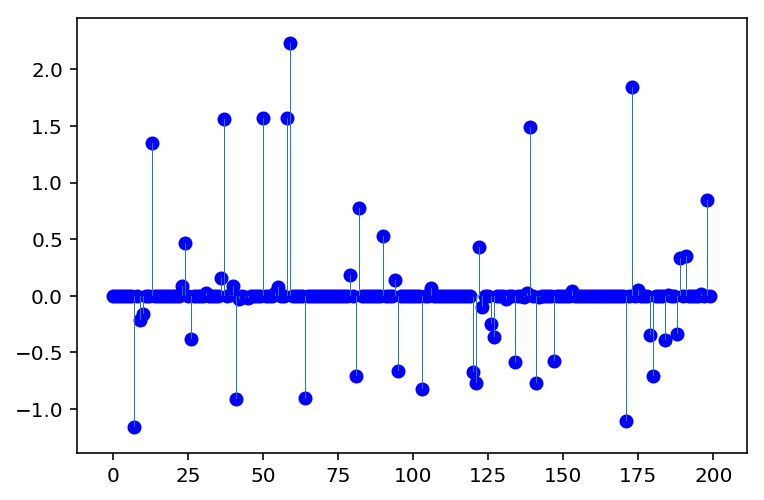

[147 147 103 139  50 134   9  13 188 173 191   9  79 191 134  79   7 122
 191]
[13]


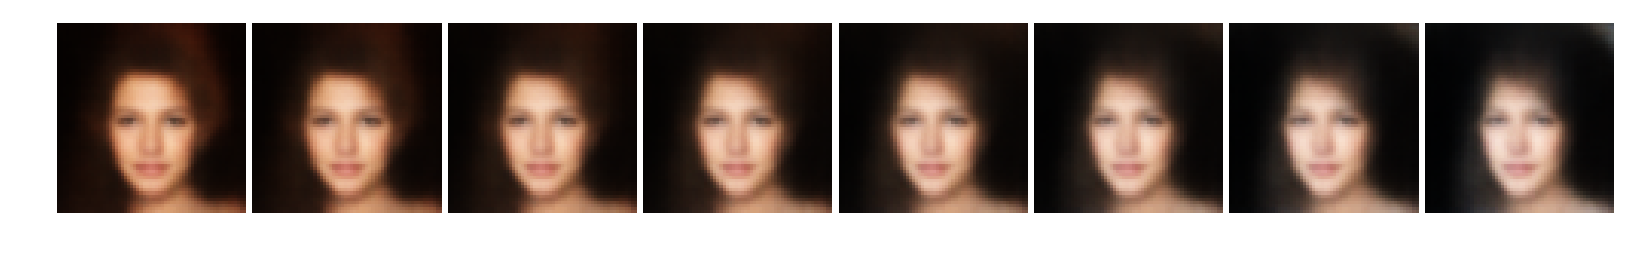

In [39]:
# 9 epochs
plot_horizontal_traversal(images[7][None,:], convvsc, 
                          model_params['latent_sz'], length=8, 
                          delta=0.7, threshold=0.1,
                          plot_all=False, 
                          plot_list=[13],
                          n_indices=19)

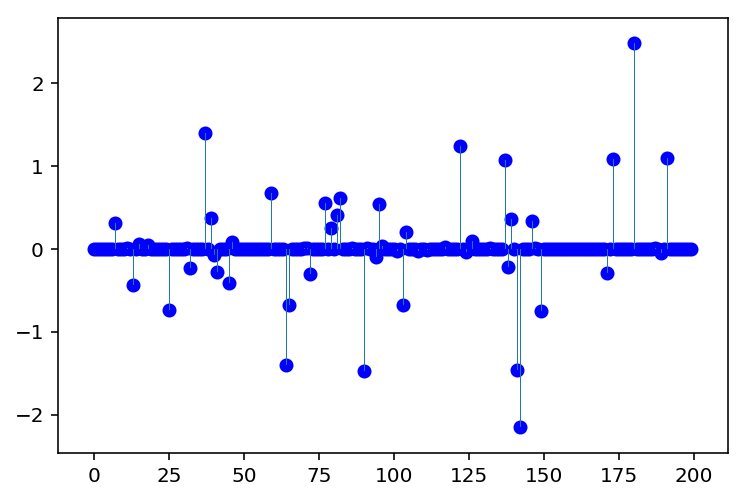

[ 64  32 149  77  59  72 122   7 139  37  90  25 146  39 191  72  77 138
  90]
[180, 122]


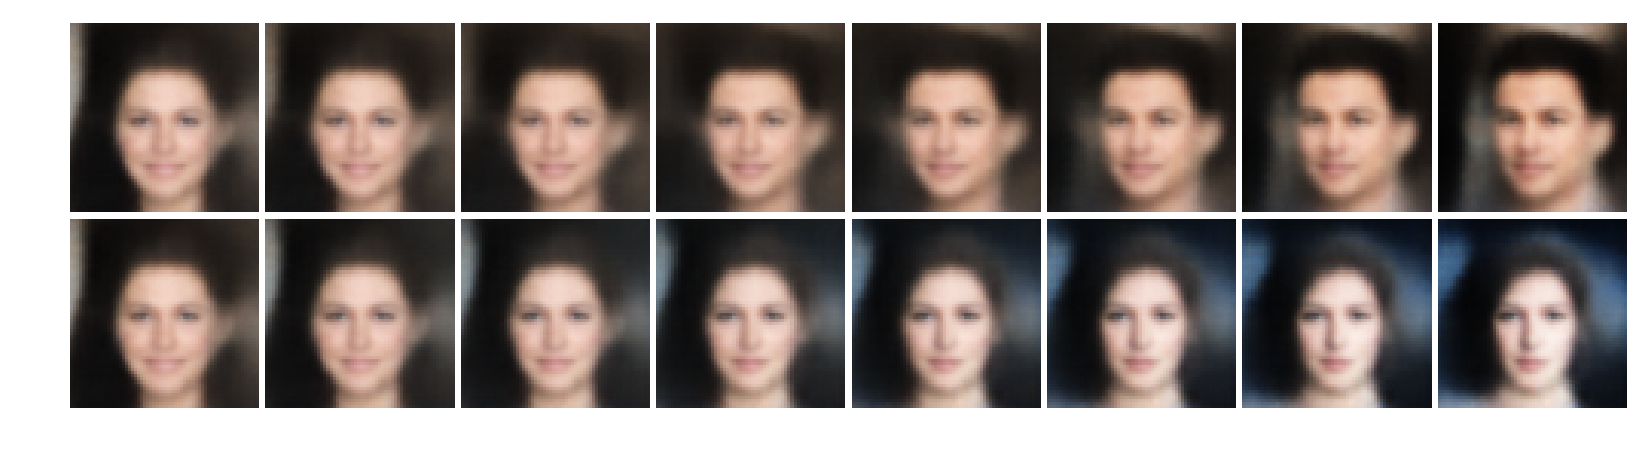

In [46]:
# 9 epochs
plot_horizontal_traversal(images[10][None,:], convvsc, 
                          model_params['latent_sz'], length=8, 
                          delta=0.9, threshold=0.1,
                          plot_all=False, 
                          plot_list=[180, 122],
                          n_indices=19)

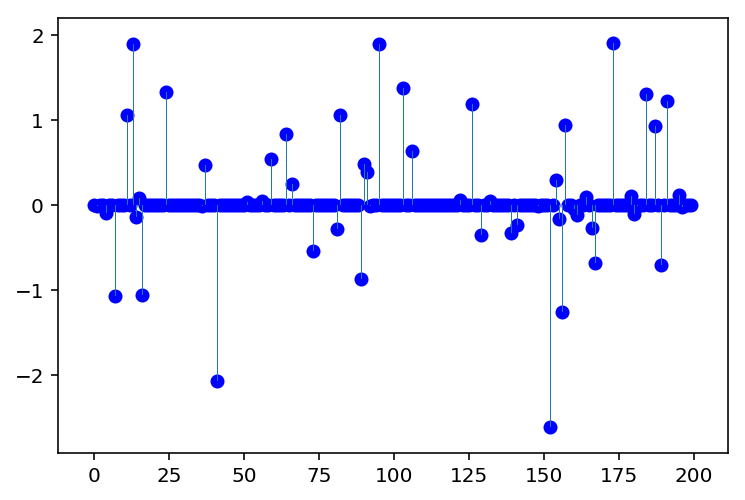

[ 66 184 106  73  24  13  24 189 129  11 126  59 191 191  91  13 184 103
 156]
[189, 41]


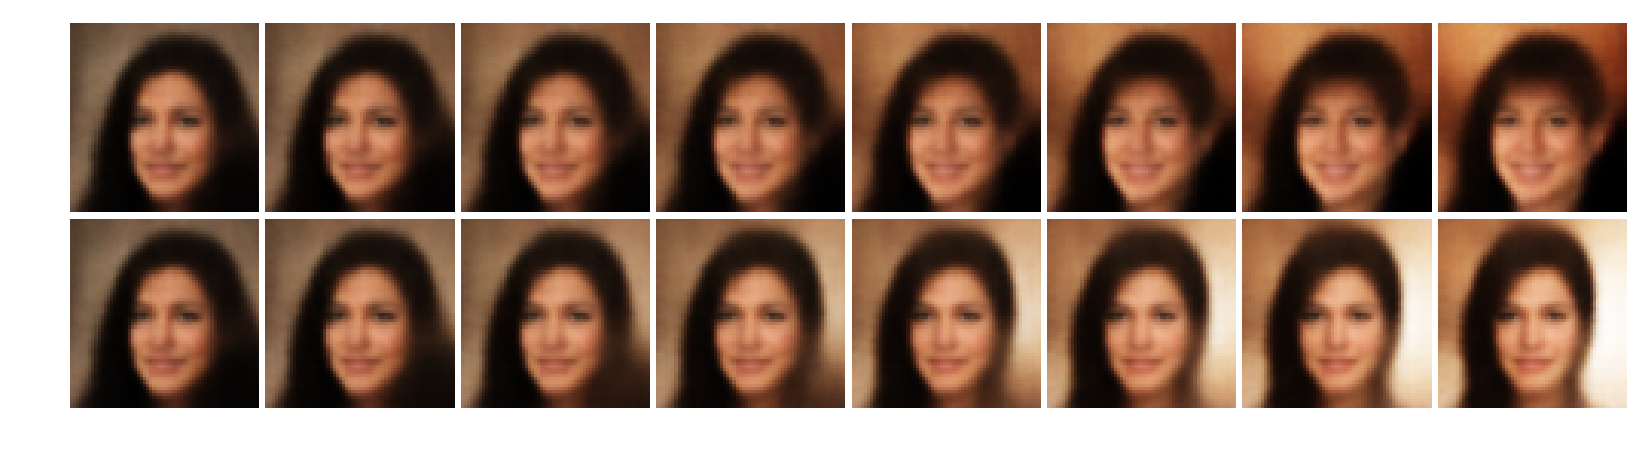

In [54]:
# 9 epochs
plot_horizontal_traversal(images[11][None,:], convvsc, 
                          model_params['latent_sz'], length=8, 
                          delta=0.7, threshold=0.1,
                          plot_all=False, 
                          plot_list=[189, 41],
                          n_indices=19)

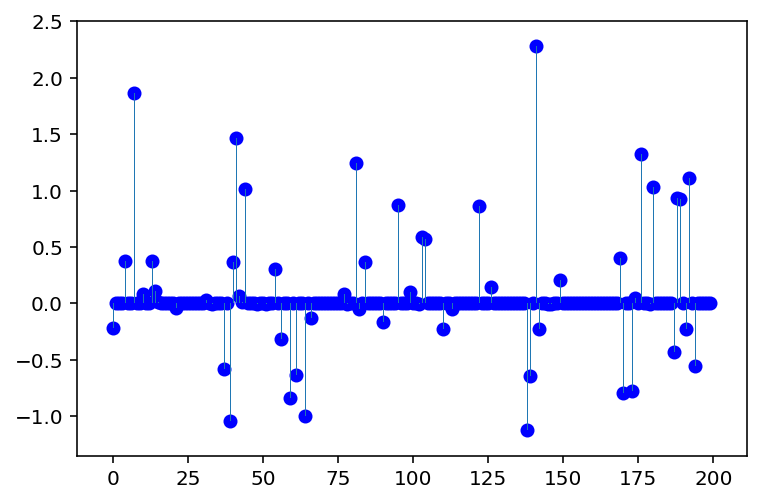

[ 61 187 139 188  37  39 149  13 126 138 189 110 173 103   0 104 138  61
 191]
[138]


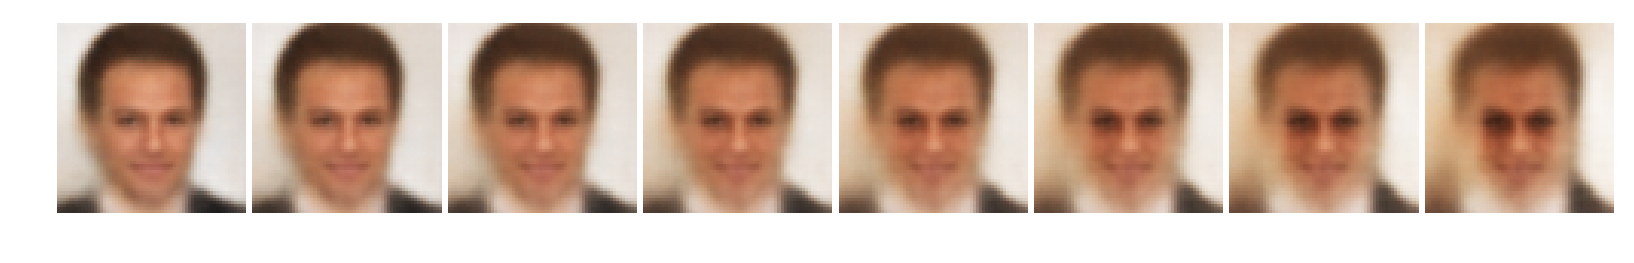

In [61]:
# 9 epochs
plot_horizontal_traversal(images[13][None,:], convvsc, 
                          model_params['latent_sz'], length=8, 
                          delta=0.6, threshold=0.1,
                          plot_all=False, 
                          plot_list=[138],
                          n_indices=19)

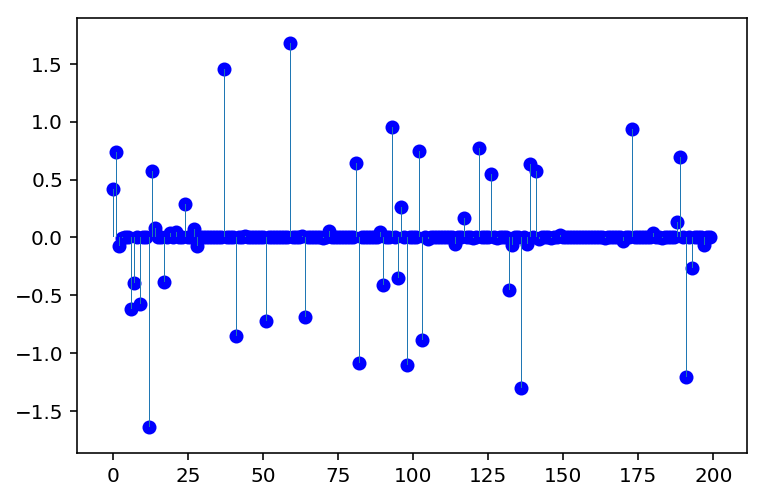

[ 17  24  41  17 141 188 132   1  51 117 173  37  93  13 102 188  90  24
  95]
[41]


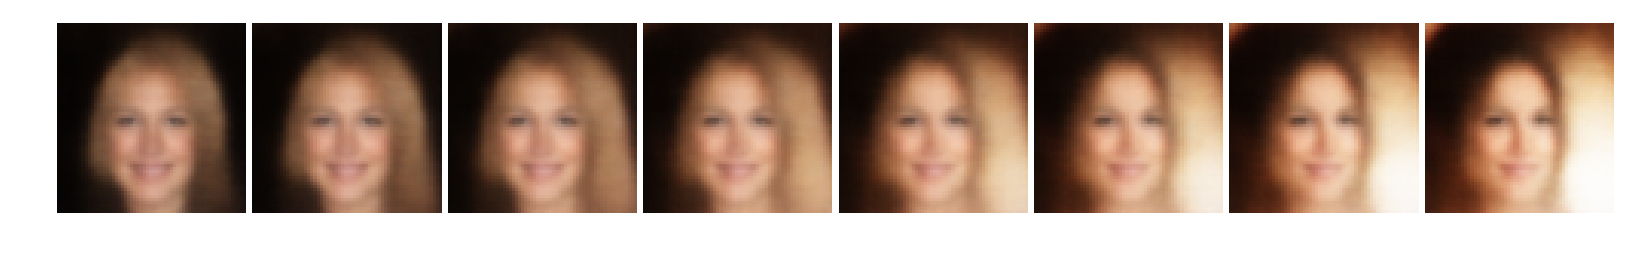

In [63]:
# 9 epochs
plot_horizontal_traversal(images[14][None,:], convvsc, 
                          model_params['latent_sz'], length=8, 
                          delta=0.7, threshold=0.1,
                          plot_all=False, 
                          plot_list=[41],
                          n_indices=19)

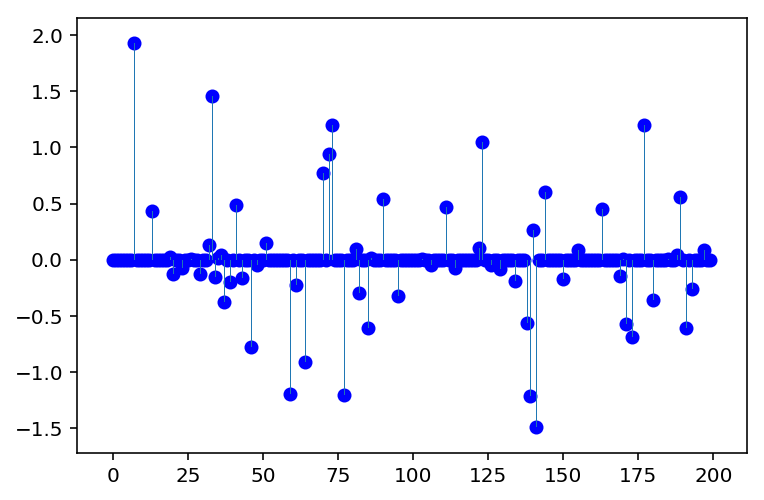

[ 73  61  90  32  29 139  41  39 140  34 123  82  64  72 169  59  85  46
  82]
[138]


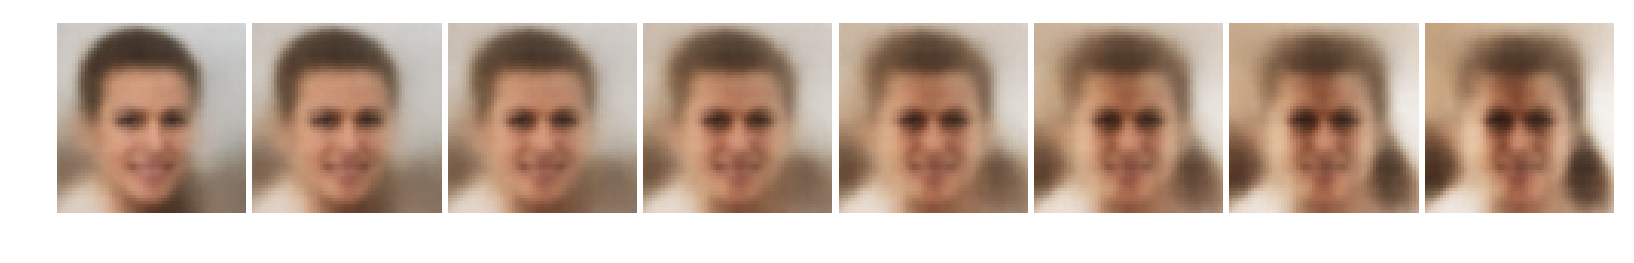

In [65]:
# 9 epochs
plot_horizontal_traversal(images[15][None,:], convvsc, 
                          model_params['latent_sz'], length=8, 
                          delta=0.7, threshold=0.1,
                          plot_all=False, 
                          plot_list=[138],
                          n_indices=19)

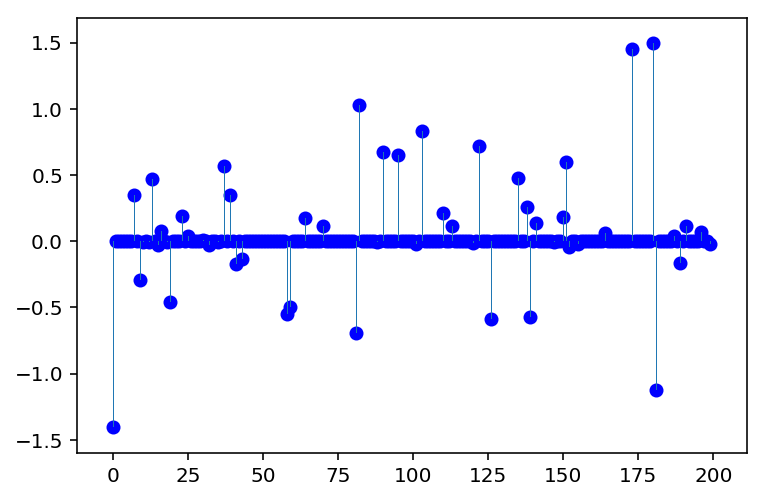

[  9  19  41 110  81  37 103 191  58 103 103 139 122 113 189 113 139  70
  95]
[189, 59, 141, 90]


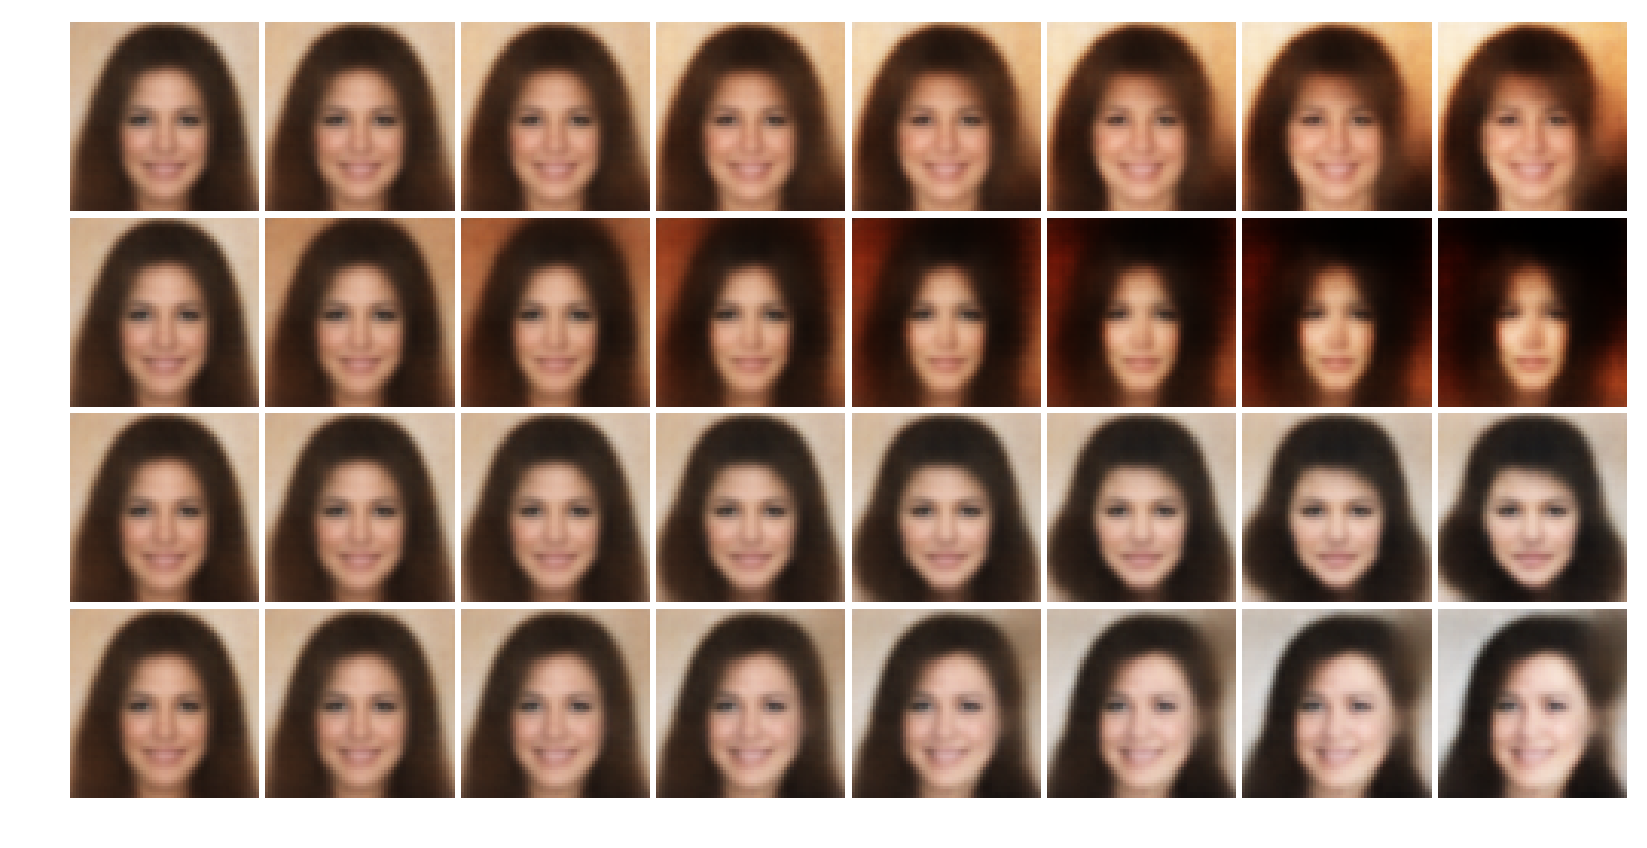

In [94]:
# 9 epochs
plot_horizontal_traversal(images[17][None,:], convvsc, 
                          model_params['latent_sz'], length=8, 
                          delta=0.7, threshold=0.1,
                          plot_all=False, 
                          plot_list=[189, 59, 141, 90],
                          n_indices=19)

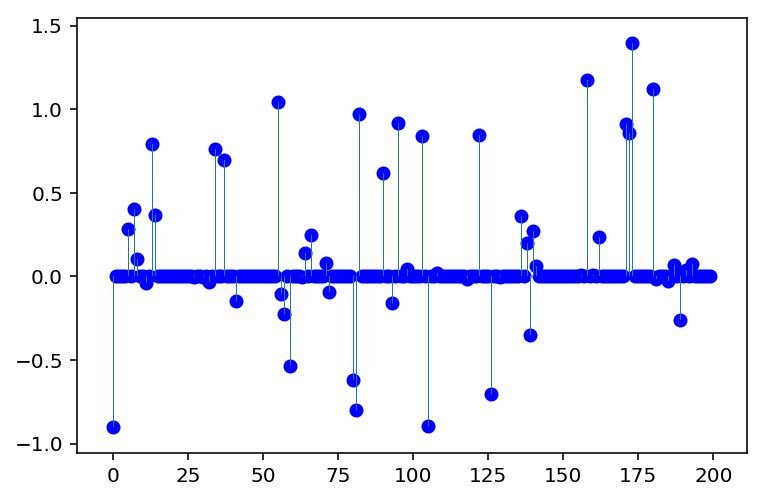

[180  59   8  59  64  82 171 126 171 136  90  57 189 103  34  93  82  56
   0]
[189, 59, 141, 90]


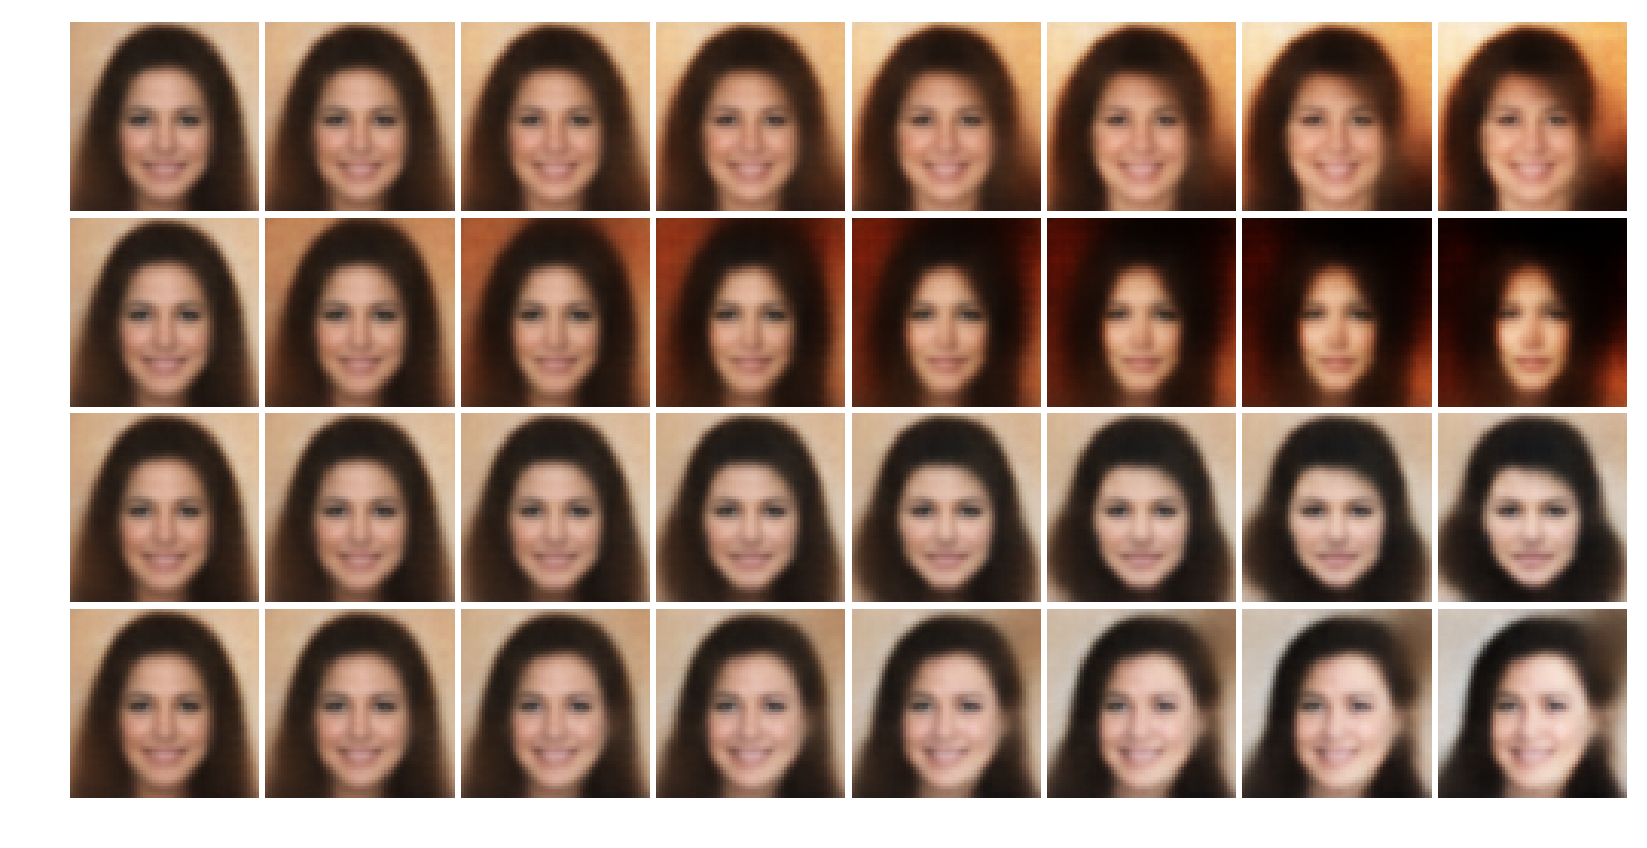

In [98]:
# 9 epochs
plot_horizontal_traversal(images[17][None,:], convvsc, 
                          model_params['latent_sz'], length=8, 
                          delta=0.7, threshold=0.1,
                          plot_all=False, 
                          plot_list=[189, 59, 141, 90],
                          n_indices=19)

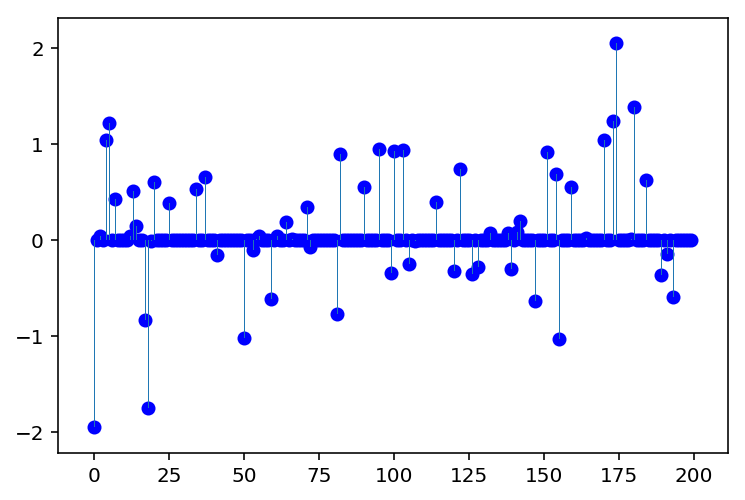

[189   5 180 173 173 142 120 191  50 180 122   5 100 105 100  41  50  34
   7]
[189, 59]


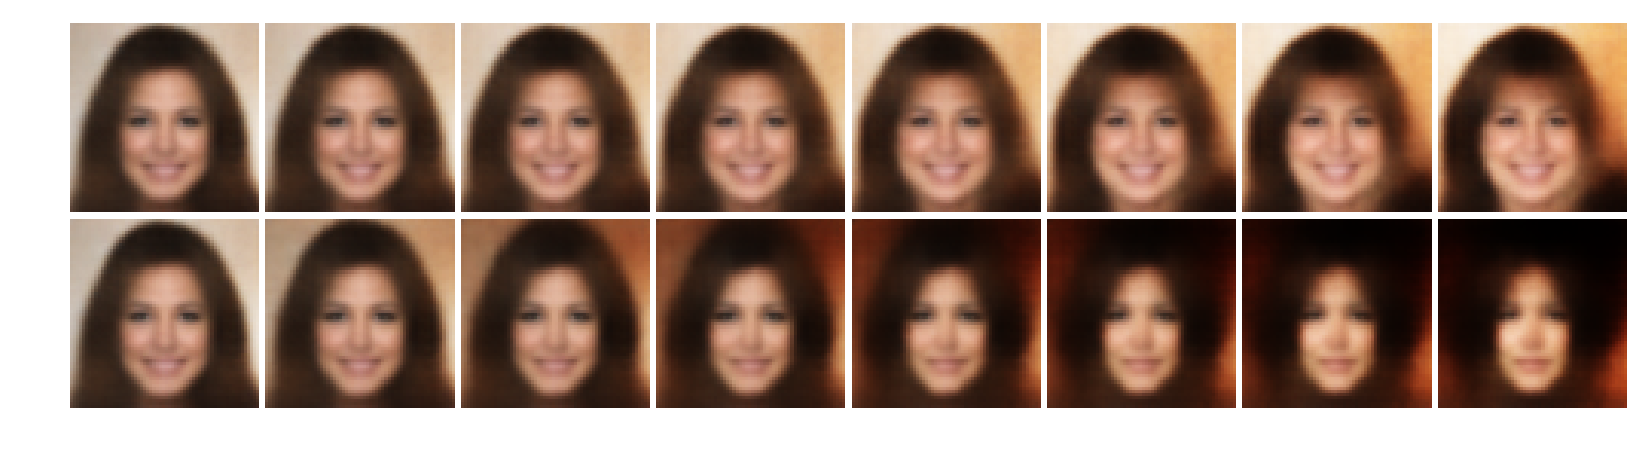

In [69]:
# 9 epochs
plot_horizontal_traversal(images[17][None,:], convvsc, 
                          model_params['latent_sz'], length=8, 
                          delta=0.7, threshold=0.1,
                          plot_all=False, 
                          plot_list=[189, 59, 141, 90],
                          n_indices=19)

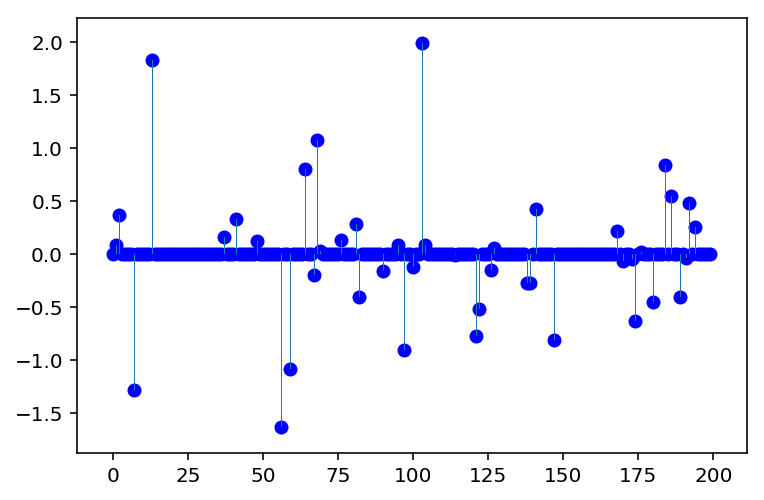

[184 126 174 126 138  90 103   7 186   7 186 100  81 194  90  13 194  68
  68]
[13, 173]


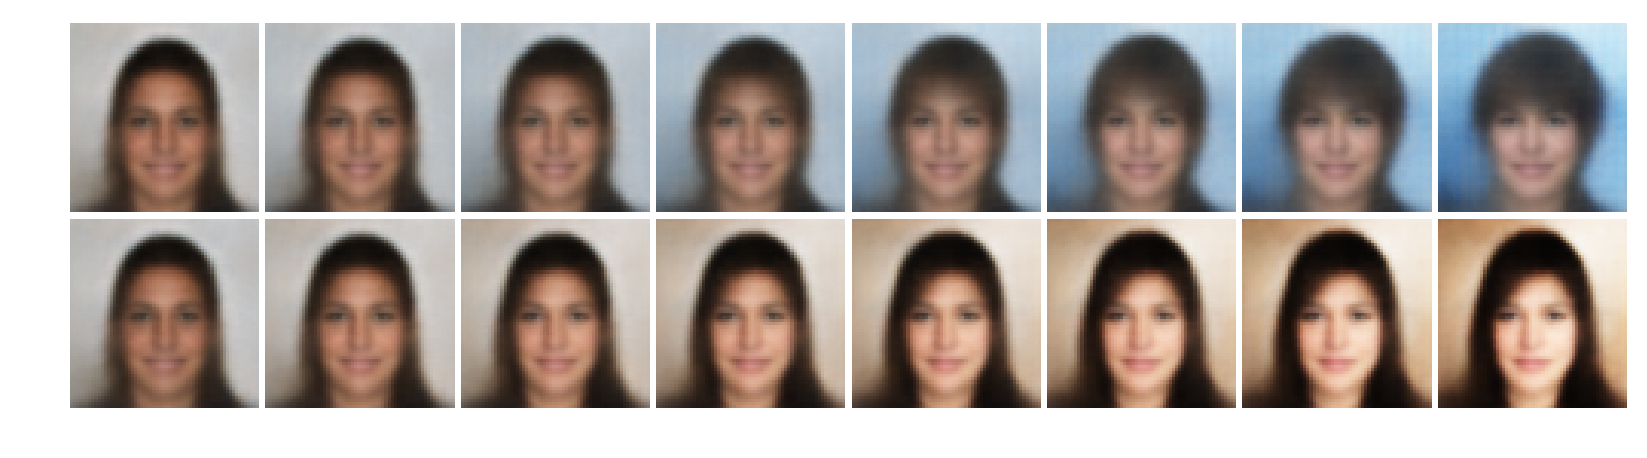

In [71]:
# 9 epochs
plot_horizontal_traversal(images[18][None,:], convvsc, 
                          model_params['latent_sz'], length=8, 
                          delta=0.7, threshold=0.1,
                          plot_all=False, 
                          plot_list=[13, 173],
                          n_indices=19)

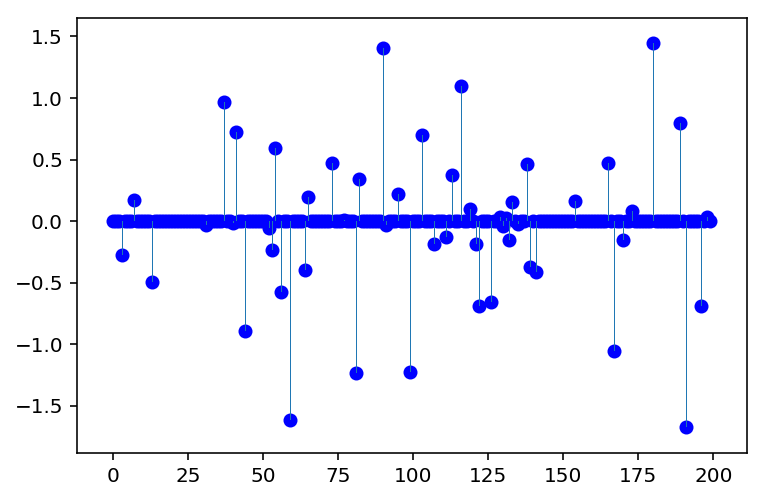

[ 73 113 111 196 122  65   7 167  95  65  99  44  81 103 133  53 139  44
 170]
[180, 59]


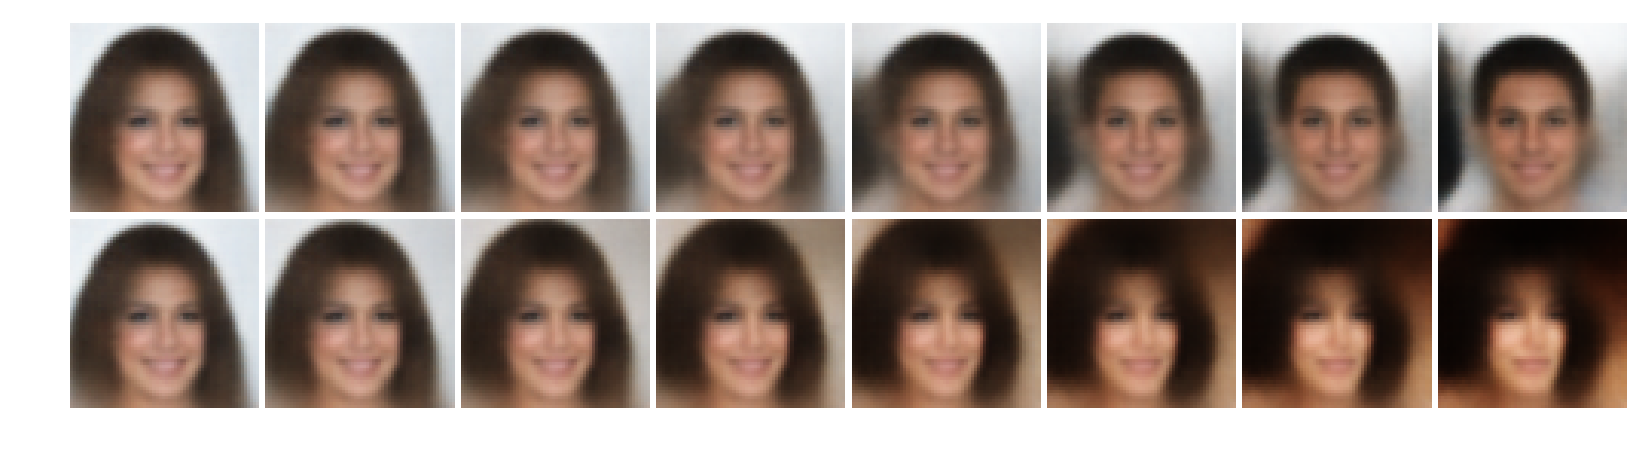

In [74]:
# 9 epochs
plot_horizontal_traversal(images[20][None,:], convvsc, 
                          model_params['latent_sz'], length=8, 
                          delta=0.7, threshold=0.1,
                          plot_all=False, 
                          plot_list=[180, 59],
                          n_indices=19)

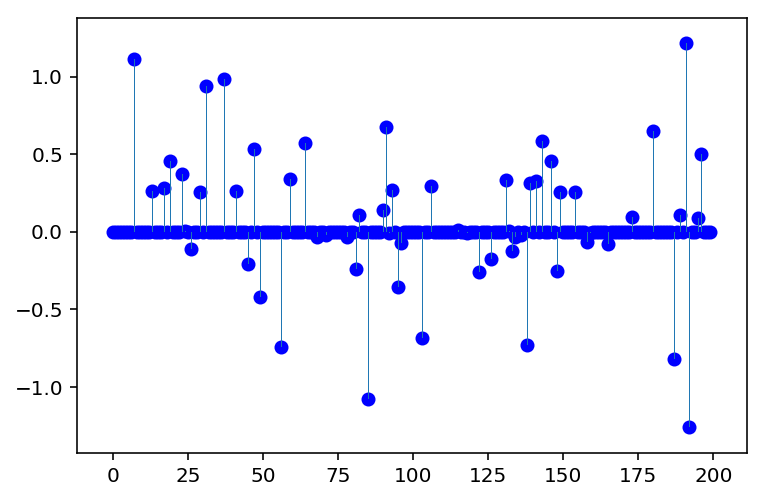

[180 131  81  64  31  47  91 138 103 149 191 143  47 122  19  85 196 180
 126]
[95, 103]


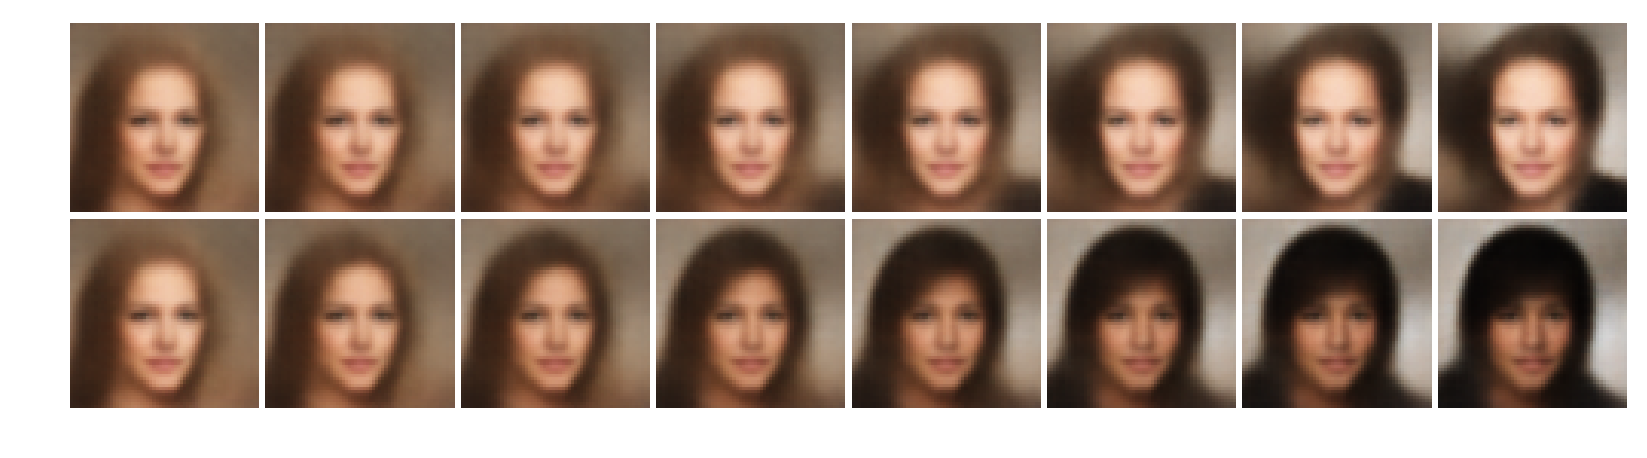

In [77]:
# 9 epochs
plot_horizontal_traversal(images[22][None,:], convvsc, 
                          model_params['latent_sz'], length=8, 
                          delta=0.7, threshold=0.1,
                          plot_all=False, 
                          plot_list=[95, 103],
                          n_indices=19)

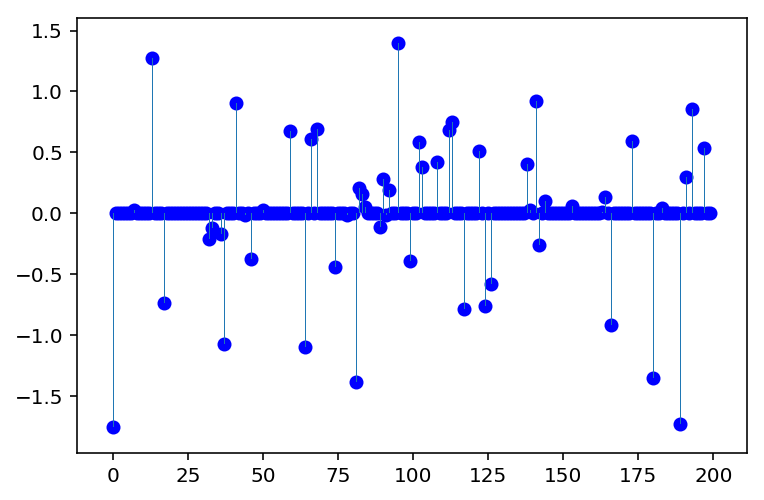

[193 138  83 117 103  64 122 108 102  68  99 126  36 141 138  82 108 144
 144]
[173]


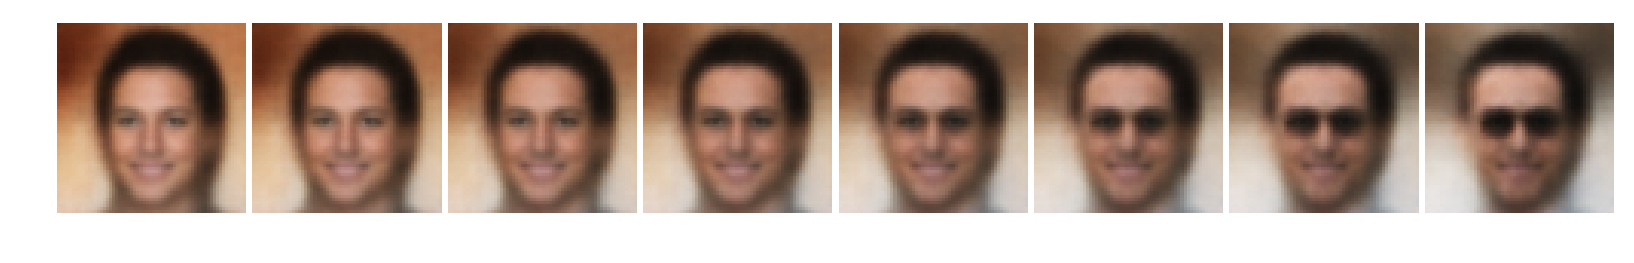

In [83]:
# 9 epochs
plot_horizontal_traversal(images[25][None,:], convvsc, 
                          model_params['latent_sz'], length=8, 
                          delta=0.5, threshold=0.1,
                          plot_all=False, 
                          plot_list=[173],
                          n_indices=19)

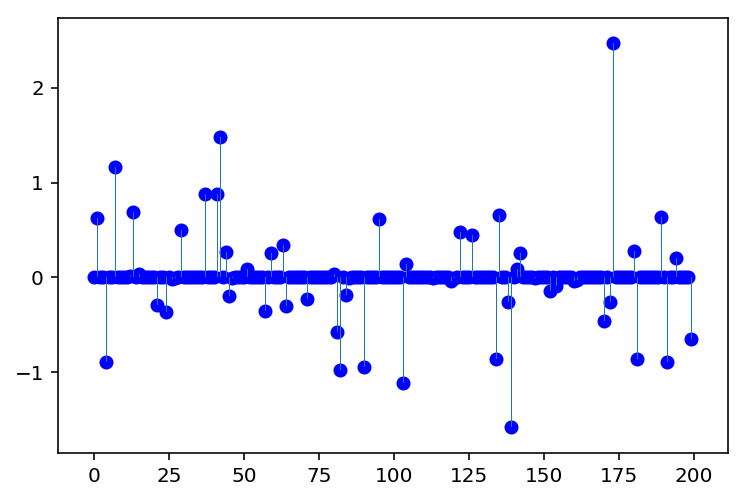

[ 45  84 122 152  44 103 173 172 170 138 135  57 181 180  84 134 181 180
   1]
[103]


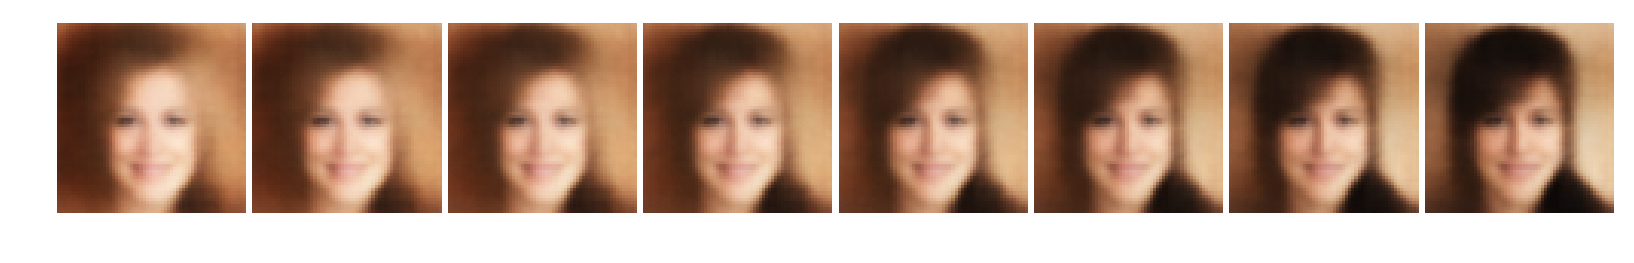

In [85]:
# 9 epochs
plot_horizontal_traversal(images[26][None,:], convvsc, 
                          model_params['latent_sz'], length=8, 
                          delta=0.5, threshold=0.1,
                          plot_all=False, 
                          plot_list=[103],
                          n_indices=19)

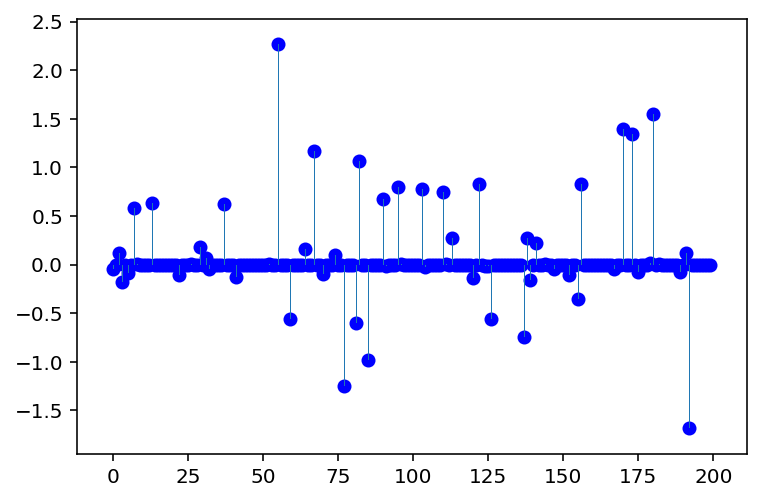

[113 141 113 113  81 155 191 180 155  90 155  64  22  37]
[113 141 113 113  81 155 191 180 155  90 155  64  22  37]


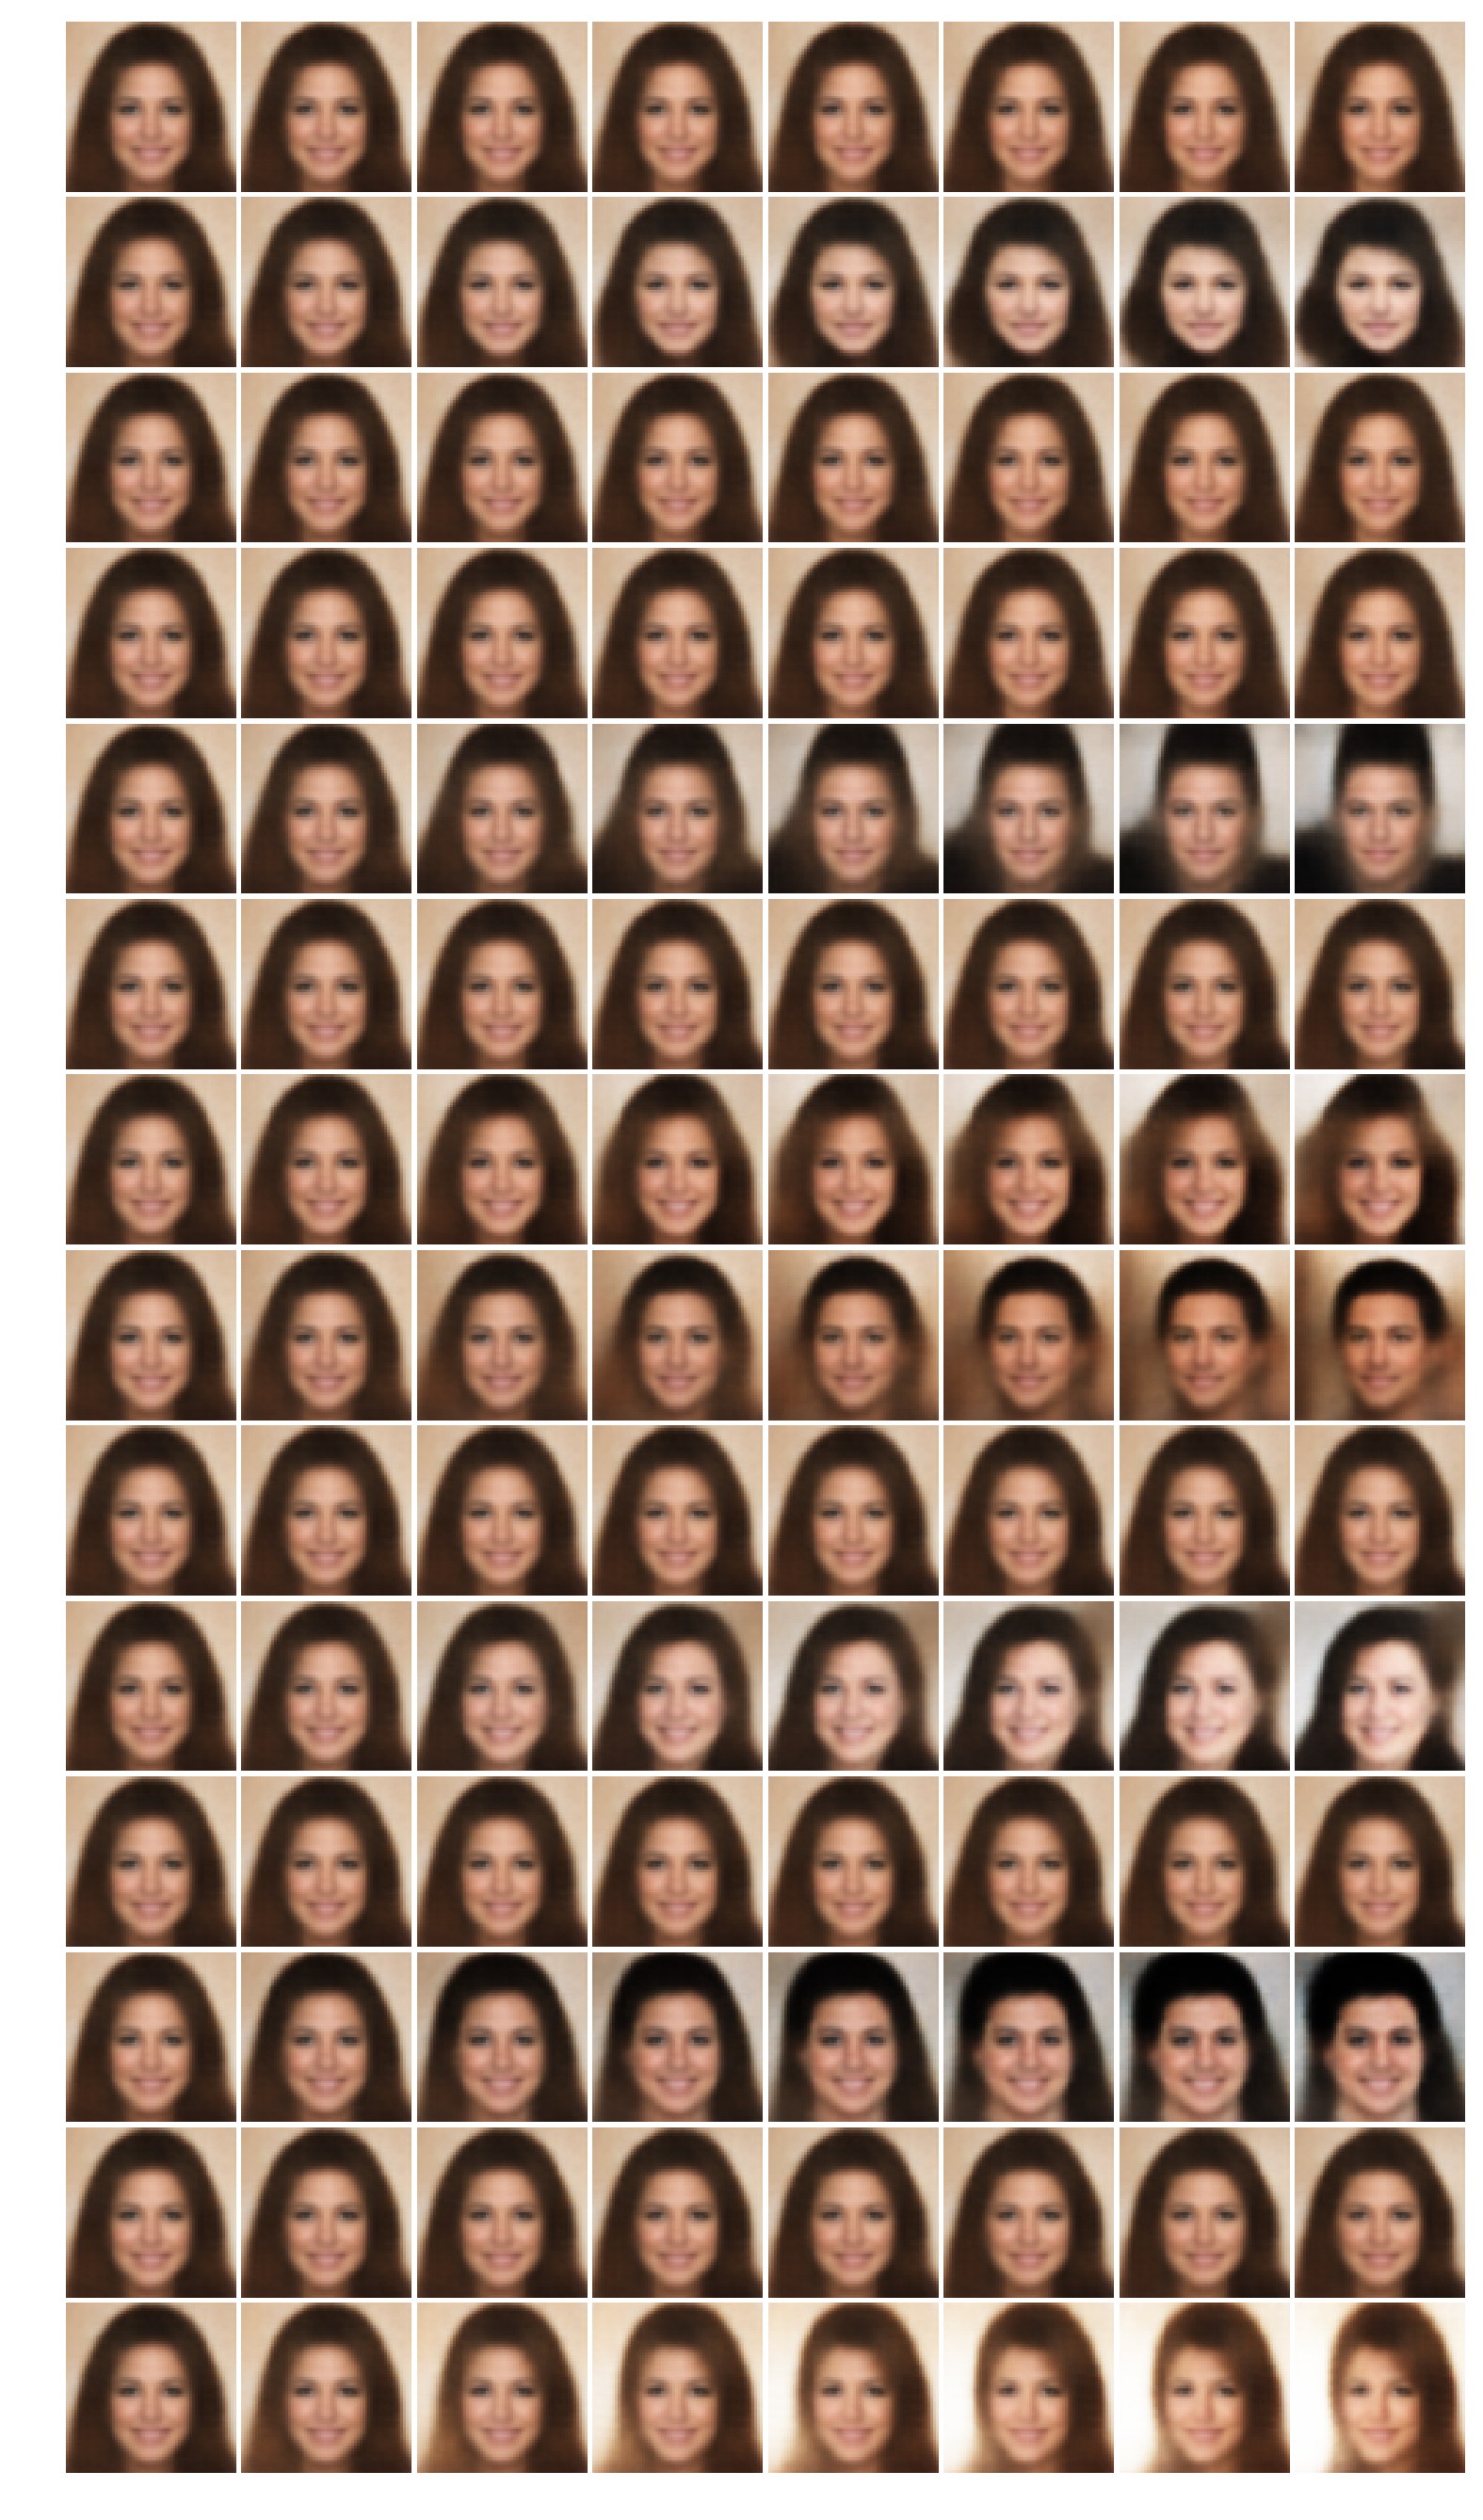

In [92]:
# 9 epochs
plot_horizontal_traversal(images[17][None,:], convvsc, 
                          model_params['latent_sz'], length=8, 
                          delta=0.7, threshold=0.1,
                          plot_all=False, 
                          plot_list=None,
                          n_indices=14)

In [99]:
import random

def plot_horizontal_traversal(image, vsc, latent_sz, length, 
                              delta, threshold=1e-4, plot_all=False, 
                              plot_list=None, width=1/4, n_indices=15):
    image = vsc.transform(image).to(vsc.device)
    decoded, mu, logvar, logspike = vsc.model.forward(image)
    z = vsc.model.reparameterize(mu, logvar, logspike)
    img = vsc.inverse_transform(vsc.model.decode(z))
    z_ = z.cpu().detach().numpy()[0]
    
#     plt.bar(np.arange(latent_sz), height=z_, width=width, align='center')
#     plt.scatter(np.arange(latent_sz), z_, color='blue')
#     plt.show()
    
    non_zero = [i for i in range(latent_sz) if np.abs(z_[i]) > threshold]
    inds = np.random.choice(non_zero, n_indices)
#     print(inds)
    
    if not plot_all:
        non_zero = inds # [ind]
    if plot_list:
        non_zero = plot_list
        
#     print(non_zero)
    
    hor_traversal = []
    for ind in non_zero:
        images = []
        z1 = z.clone()
        for i in range(length):
            img = to_numpy(vsc.model.decode(z1), vsc)
            img = np.transpose(img, (1,2,0))
            img[:,0] = 1
            img[:,-1] = 1
            img[0,:] = 1
            img[-1,:] = 1
            images.append(img)
            z1[0, ind] = z1[0, ind] + delta if z[0,ind] < 0 else z1[0, ind] - delta

        hor_traversal.append(np.concatenate(images, axis=1))
    traversal = np.concatenate(hor_traversal, axis=0)
#     plt.figure(figsize=(14,24))
#     plt.axis('off')
#     plt.imshow(traversal)
#     plt.show()
    return traversal

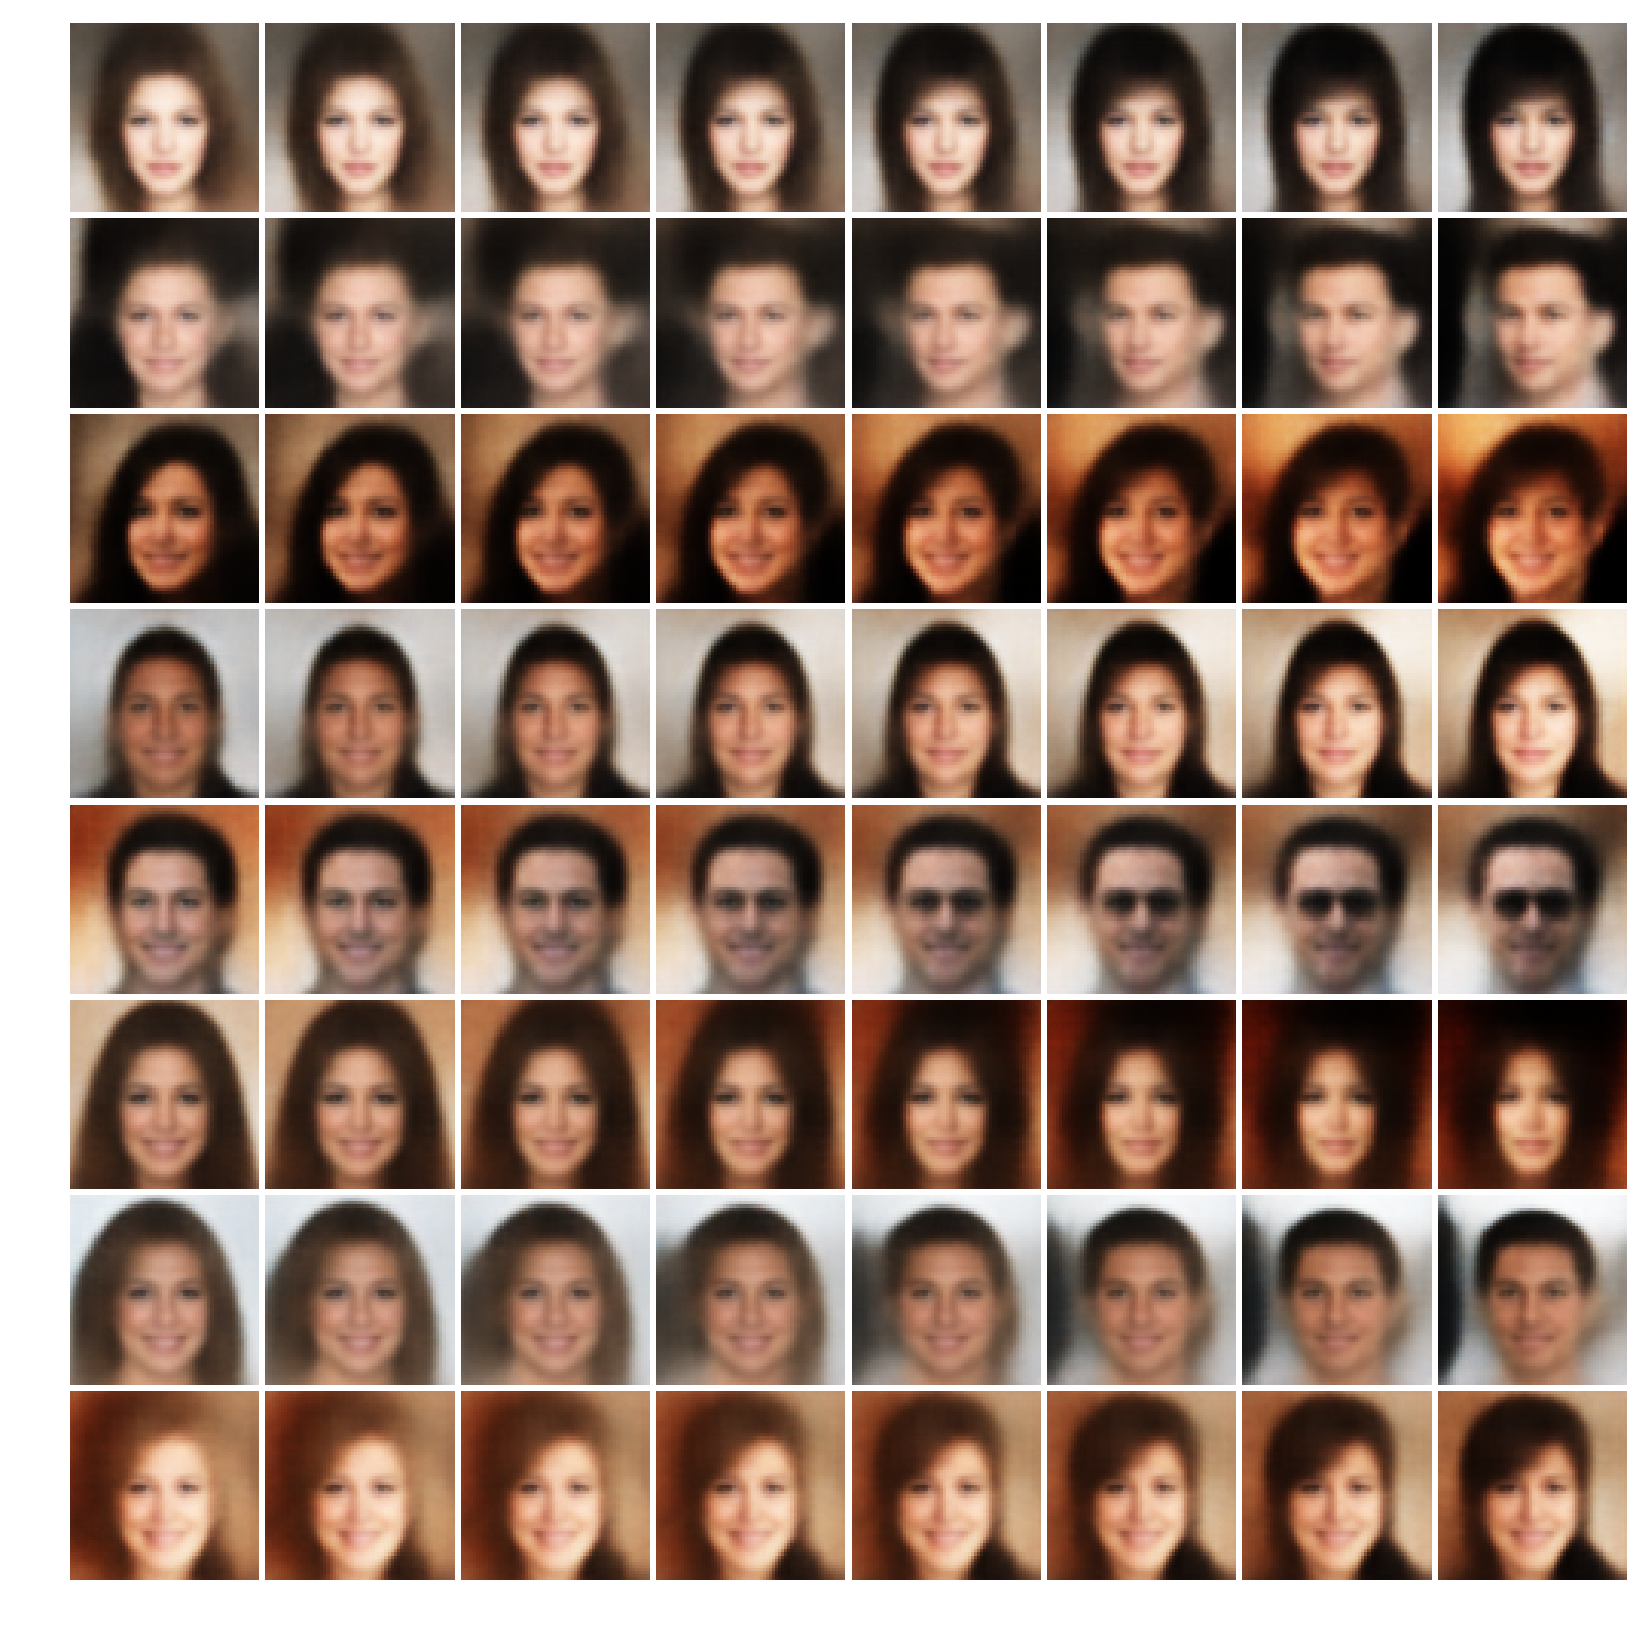

In [106]:
# 9 epochs
traversals = np.concatenate([
    plot_horizontal_traversal(images[img_idx][None,:], convvsc, 
                          model_params['latent_sz'], length=8, 
                          delta=delta, threshold=0.01,
                          plot_all=False, 
                          plot_list=[dim],
                          n_indices=19)
    for img_idx, delta, dim in [
#         (7, 0.7, 13),
#         (17, 0.7, 90),
#         (22, 0.7, 103),
        
        (1, 0.5, 103),
        (10, 0.9, 180),
        (11, 0.9, 189),
        (18, 0.7, 173),
        (25, 0.5, 173),
        (17, 0.6, 59),
        (20, 0.8, 180),
#         (22, 0.7, 95),
        (26, 0.5, 103)
    ]
])

plt.figure(figsize=(14,24))
plt.axis('off')
plt.imshow(traversals)
plt.show()